In [1]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.interpolate
import astropy.units as u
import astropy.constants

import simdata

In [232]:
# very hard example

# simid = "4ae2169c"
# Noutput = 30

# hard example

simid = "306d9f0c"
Noutput = 52

# overlapping with boundary example

# simid = "9f976424"
# Noutput = 90

# elongated vortex example

# simid = "487fa644"
# Noutput = 222

# # big vortex example
# simid = "3625e016"
# Noutput = 200

# easy example

# simid = "a122b63c"
# Noutput = 75

# # faint vortex
# simid = "65a701a4"
# Noutput = 380

# another faint vortex
# simid = "b522b88a"
# Noutput = 116

# no vortex

# simid = "3401c4d0"
# Noutput = 256

# 8cps x 2cps example

# simid = "65a701a4"
# Noutput = 50

# 16 cps example
# simid = "20ce240c"
# Noutput = 82 # overlapping with spiral, need 0.2 spacing in vortensity
# Noutput = 83
# Noutput = 84 # hard case barely passing

# easier 16 cps example
# simid = "71cfb245"
# Noutput = 54

# transition disk example
# vortex in migration jump paper
# simid = "d132cf47"
# Noutput = 524


simulation = simdata.SData(simid)

## Vorticity calculation for simdata

In [233]:
def map_angles(phi, phi_min=-np.pi):
    """ Map angles to the range [phi_min, phi_min + 2pi]

    Parameters
    ----------
    phi: float
        Angles to map.
    phi_min: float
        Lower bound.
    """
    phi_max = phi_min + 2*np.pi
    phi = phi % (2*np.pi)
    if isinstance(phi, np.ndarray):
        phi[phi > phi_max] -= 2*np.pi
    else:
        if phi > phi_max:
            phi -= 2*np.pi
    return phi


def vorticity_simdata(data, Noutput, rref=None):
    vrad = data.fluids["gas"].get("2d", "velocity radial", Noutput)
    rs = vrad.grid.get_centers("r")
    phi = vrad.grid.get_centers("phi")

    PHI, R = np.meshgrid(phi, rs)

    t = vrad.get_time()
    try:
        omega_frame = data.planets[0].get(
            "omega frame").get_closest_to_time(t).to("s-1")
    except KeyError:
        omega_frame = (1/data.loader.units["time"]).to("s-1")

    dvrad_dphi = derivative_vrad_phi(data, Noutput)
    duazi_dr, uazi = derivative_vazi_r(data, Noutput, rref=rref)

    vorticity = 2*omega_frame + uazi/R + duazi_dr - dvrad_dphi/R
    return vorticity


def derivative_vrad_phi(data, Noutput):
    vrad = data.fluids["gas"].get("2d", "velocity radial", Noutput)

    rsi = vrad.grid.get_coordinates("r")
    phii = vrad.grid.get_coordinates("phi")

    PHIi, Ri = np.meshgrid(phii, rsi)

    rsc = vrad.grid.get_centers("r")
    phic = vrad.grid.get_centers("phi")
    PHIc, Rc = np.meshgrid(phic, rsc)

    if data.loader.code_info[0].lower().startswith("fargo"):
        Rplus = Ri[1:, :]
        Rminus = Ri[:-1, :]
        vplus = vrad.data[1:, :]
        vminus = vrad.data[:-1, :]
        # interpolate to cell centers
        vr = vminus + (vplus - vminus)/(Rplus - Rminus)*(Rc-Rminus)
    elif data.loader.code_info[0].lower().startswith("pluto"):
        vr = vrad.data
    dvrad_dphi = np.gradient(vr.to_value('cm/s'), phic.to_value('rad'), axis=1)
    return dvrad_dphi*u.cm/u.s


def derivative_vazi_r(data, Noutput, rref=None):
    vazi = data.fluids["gas"].get("2d", "velocity azimuthal", Noutput)

    try:
        Mstar = data.planets[0].get("mass")[0]
    except KeyError:
        Mstar = 1*u.solMass
        print("Warning: Assumed a start mass of 1 solar mass!")

    if rref is not None:
        rref = rref*u.au
        v_K = np.sqrt(astropy.constants.G*Mstar/rref).to("cm/s")
        omega_frame = data.planets[0].get(
            "omega frame").get_closest_to_time(vazi.get_time()).to("s-1")
        v_Frame = omega_frame*rref
        v_azi_rot = vazi.data + v_Frame - v_K
    else:
        v_azi_rot = vazi.data

    rsi = vazi.grid.get_centers("r")
    phii = vazi.grid.get_interfaces("phi")

    PHIi, Ri = np.meshgrid(phii, rsi)
    rsc = vazi.grid.get_centers("r")
    phic = vazi.grid.get_centers("phi")
    PHIc, Rc = np.meshgrid(phic, rsc)

    PHIplus = PHIi[:, 1:]
    PHIminus = PHIi[:, :-1]
    vplus = np.roll(v_azi_rot, 1, axis=1)
    vminus = v_azi_rot

    va = vminus + (vplus - vminus)/(PHIplus - PHIminus)*(PHIc-PHIminus)

    dvazi_dr = np.gradient(va.to_value('cm/s'), rsc.to_value('cm'), axis=0)
    return dvazi_dr/u.s, va


def velocity_cartesian_simdata(data, Noutput):
    vrad = data.fluids["gas"].get("2d", "velocity radial", Noutput)
    vazi = data.fluids["gas"].get("2d", "velocity azimuthal", Noutput)

    rs = vrad.grid.get_centers("r")
    phi = vrad.grid.get_centers("phi")

    PHI, R = np.meshgrid(phi, rs)

    x = R*np.cos(PHI)
    y = R*np.sin(PHI)

    # centered velocities
    vrad_c = vrad.data[:-1, :]
    #vazi_c = vazi.data - np.tile(np.mean(vazi.data, axis=1), (vazi.data.shape[1], 1) ).transpose()
    G = astropy.constants.G
    try:
        Mstar = data.planets[0].get("mass")[0]
    except KeyError:
        Mstar = 1*u.solMass
        print("Warning: Assumed a start mass of 1 solar mass!")
    v_K = np.sqrt(G*Mstar/R).to("cm/s")
    v_Frame = 0.5*1.6792048484108891e-08*1/u.s*R
    vazi_c = vazi.data - v_K + v_Frame

    vx = vrad_c*np.cos(PHI) - vazi_c*np.sin(PHI)
    vy = vrad_c*np.sin(PHI) + vazi_c*np.cos(PHI)

    return (x, y, vx, vy)

In [234]:
M_star = 1*u.solMass
rho = simulation.fluids["gas"].get("2d", "mass density", Noutput)
r = rho.grid.get_centers("r")
phi = rho.grid.get_interfaces("phi")
phi = map_angles(phi.to_value("rad"))
if np.isclose(phi[-1],-np.pi):
    phi[-1] = np.pi
phi = phi*u.rad
PHI_rho, R_rho = np.meshgrid(phi, r)
x_rho = R_rho*np.cos(PHI_rho)
y_rho = R_rho*np.sin(PHI_rho)
phi_c = rho.grid.get_centers("phi")
phi_c = map_angles((phi_c).to_value("rad"))
if phi_c[-1] == 0.0:
    phi_c[-1] = 2*np.pi
phi_c = phi_c*u.rad
PHI_c, R_c = np.meshgrid(phi_c, r)
xc = R_c*np.cos(PHI_c)
yc = R_c*np.sin(PHI_c)

dr = rho.grid.get_sizes("r").to_value("au")
dphi = rho.grid.get_sizes("phi").to_value("rad")
DPHI, DR = np.meshgrid(dphi, dr)

In [235]:
vorticity = vorticity_simdata(simulation, Noutput)
Omega_Kepler = np.sqrt(astropy.constants.G * M_star / R_c**3).decompose()
vorticity_Kepler = (0.5*Omega_Kepler).to("1/s")
vorticity = vorticity.to_value(1/u.s)
vorticity = (vorticity/vorticity_Kepler).decompose().value

Rho_background = simulation.fluids["gas"].get("2d", "mass density", 0).data.to_value("solMass/au2")
Rho = simulation.fluids["gas"].get("2d", "mass density", Noutput).data.to_value("solMass/au2")
vortensity = vorticity/rho.data.to_value("solMass/au2")*Rho_background

vortensity[vortensity < -1] = -1

# vortensity = np.exp(vorticity)

In [236]:
X = R_rho.to_value("au")
Y = PHI_rho.to_value("rad")
Xc = R_c.to_value("au")
Yc = PHI_c.to_value("rad")
R = Xc
A = DR*R*DPHI

In [237]:
N_roll = -np.argmax(phi[1:] - phi[:-1] < 0)
X = np.roll(X, N_roll, axis=1)
Y = np.roll(Y, N_roll, axis=1)
Xc = np.roll(Xc, N_roll, axis=1)
Yc = np.roll(Yc, N_roll, axis=1)
vorticity = np.roll(vorticity, N_roll, axis=1)
vortensity = np.roll(vortensity, N_roll, axis=1)
Rho = np.roll(Rho, N_roll, axis=1)
Rho_background = np.roll(Rho_background, N_roll, axis=1)

## Test vortector class implementation

In [238]:
%reload_ext autoreload
%autoreload 2
%load_ext line_profiler
from importlib import reload
from pprint import pprint
import vortector

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [239]:
levels = [float(x) for x in np.arange(-1,1.5,0.05)]
# levels = [float(x) for x in np.arange(-1,1.5,0.1)]

CPU times: user 2.5 s, sys: 1.56 s, total: 4.06 s
Wall time: 4.05 s
strength = 5.99e-05, mass = 8.76e-05 , min vort = 0.300, sigma fit r_diff = 4.10e-02 phi_diff = 9.25e-03
strength = 1.55e-05, mass = 2.63e-05 , min vort = 0.514, sigma fit r_diff = 4.95e-01 phi_diff = 6.03e+00


Text(0.5, 1.0, 'phi, ref=sigma')

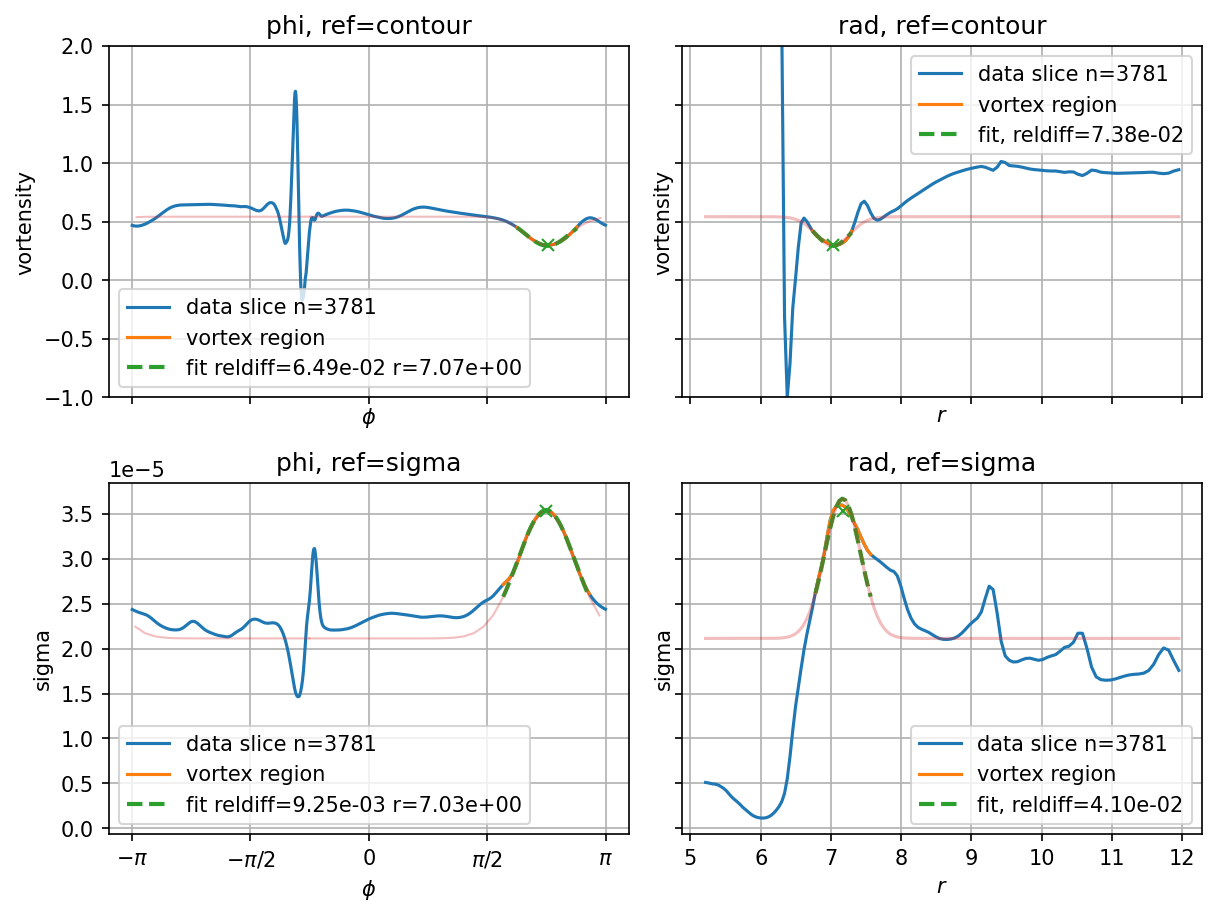

In [240]:
vd = vortector.Vortector(Xc, Yc, A, vortensity, Rho, Rho_background,
                         [5.2,12], verbose=False, med=0.15, mear=np.inf,
                         levels=levels
                        )
# vd = vortector.Vortector(Xc, Yc, A, vortensity, Rho, Rho_background,
#                          [40,80], verbose=False, med=0.15, mear=np.inf,
#                          levels=levels
#                         )
%time vortices = vd.detect_vortex(include_mask=True)
for v in vortices:
    try:
        v["strength"] = np.exp(-v["vortensity_median"])*v["mass"]
        print("strength = {:.2e}, mass = {:.2e} , min vort = {:.3f}, sigma fit r_diff = {:.2e} phi_diff = {:.2e}".format(
            v['strength'],v['mass'],v['vortensity_min'],v["sigma_fit_r_reldiff"],v["sigma_fit_phi_reldiff"]))
    except KeyError:
        pass
# pprint(vortices)

fig, axes = plt.subplots(2,2, dpi=150, figsize=(8,6), constrained_layout=True, sharex="col", sharey="row")
axes = axes.flatten()
ax = axes[1]
key = "vortensity"
ref = "contour"
vd.show_radial_fit(ax, key, 0, ref=ref)
ax.set_title(f"rad, ref={ref}")
ax.set_ylim(-1, 2)

ax = axes[0]
vd.show_azimuthal_fit(ax, key, 0, ref=ref)
ax.set_title(f"phi, ref={ref}")
ax.set_ylim(-1, 2)

# fig, axes = plt.subplots(1,2, dpi=150, figsize=(8,3), constrained_layout=True)
# axes = axes.flatten()
# print(type(axes))
ax = axes[3]
key = "sigma"
ref = "sigma"
center = "sigma"
vd.show_radial_fit(ax, key, 0, ref=ref, center=center)
ax.set_title(f"rad, ref={ref}")

ax = axes[2]
vd.show_azimuthal_fit(ax, key, 0, ref=ref, center=center)
ax.set_title(f"phi, ref={ref}")

In [241]:
#import cProfile
#cProfile.run("vd.detect_vortex(include_mask=True)", sort="cumtime")

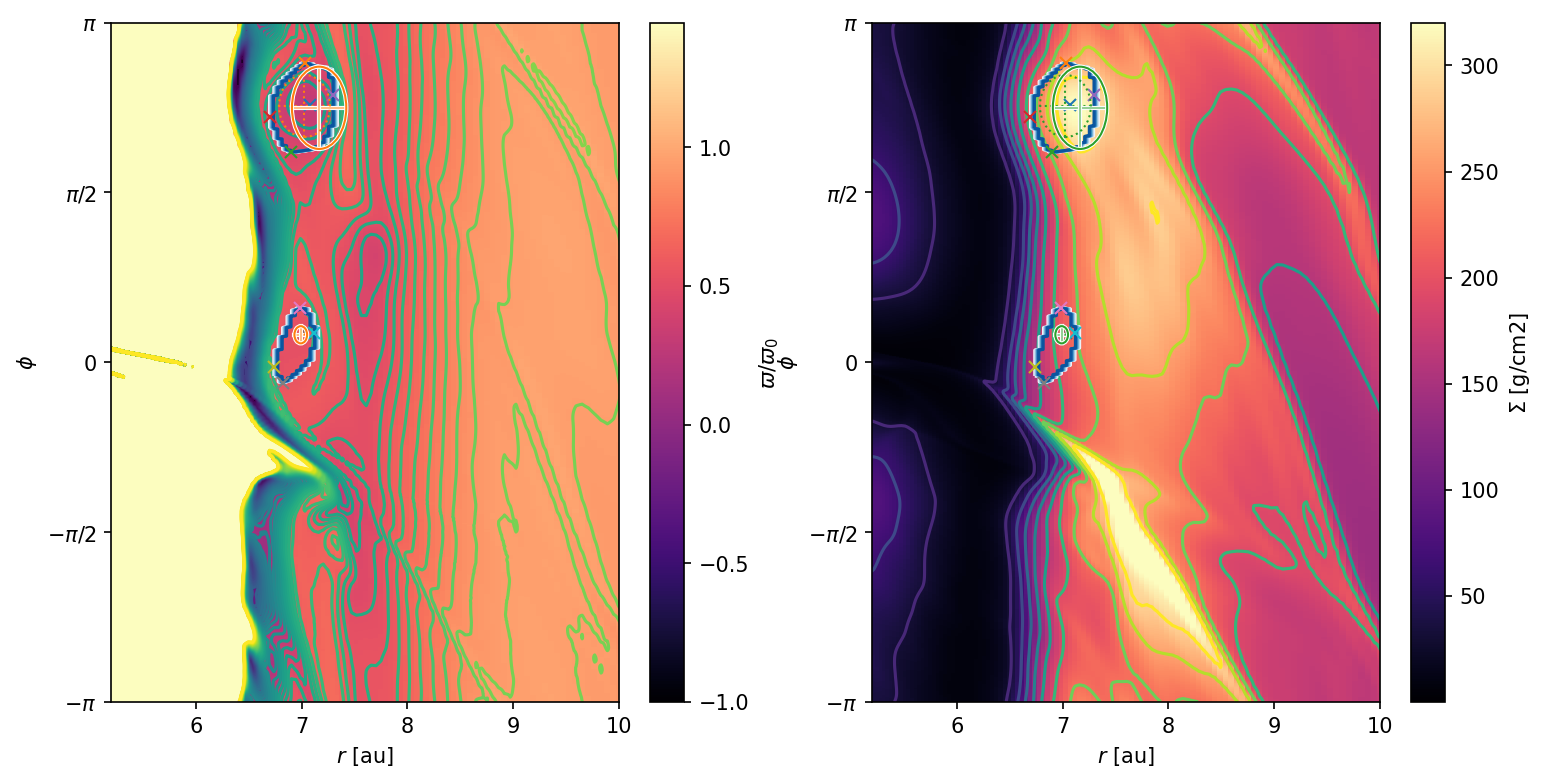

In [251]:
from matplotlib.patches import Ellipse
import matplotlib.patheffects as pe

fig, axes = plt.subplots(1,2, figsize=(12,6),dpi=150)
# ax.set_xscale("log")

ax = axes[0]
Z = vortensity
cmap = "magma"
norm = colors.Normalize(vmin=levels[0], vmax=levels[-1])
img_vortensity = ax.pcolormesh(Xc, Yc, Z,cmap=cmap,norm=norm, rasterized=True, shading="auto")

ax.contour(Xc, Yc, Z, levels=levels)

ax = axes[1]
Z = Rho
solar_to_cgs = (1*u.solMass/u.au**2).to_value("g/cm2")
Z = Z*solar_to_cgs
cmap = "magma"

vmax = vortices[0]["sigma_max"]*solar_to_cgs
norm = colors.Normalize(vmin=1e-2, vmax=vmax)
img_sigma = ax.pcolormesh(Xc, Yc, Z,cmap=cmap,norm=norm, rasterized=True, shading="auto")

ax.contour(Xc, Yc, Z, levels=np.arange(0,vmax,vmax/10))

show_bounding_lines = False
show_bounding_points = True
show_fits = True

def plot_vline_periodic(ax, x, y, dy, **kwargs):
    bup = np.pi
    blow = -np.pi
    L = bup - blow
    y = (y-blow) % L + blow
    
    at_upper_bnd = y + dy > bup
    at_lower_bnd = y - dy < blow
    if at_upper_bnd:
        line, = ax.plot([x, x], [y-dy, bup], **kwargs)
        c = line.get_color()
        ls = line.get_linestyle()
        lw = line.get_linewidth()
        ax.plot([x,x], [blow, y-L+dy], ls=ls, lw=lw, c=c)
    elif at_lower_bnd:
        line, = ax.plot([x, x], [y+dy, blow], **kwargs)
        c = line.get_color()
        ls = line.get_linestyle()
        lw = line.get_linewidth()
        ax.plot([x,x], [bup, y+L-dy], ls=ls, lw=lw, c=c)
    else:
        ax.plot([x, x], [y-dy, y+dy], **kwargs)

        
for ax, fit_color, varname, img in zip(axes, ["C1", "C2"], [r"$\varpi/\varpi_0$", r"$\Sigma$ [g/cm2]"], [img_vortensity, img_sigma]):
    for n,vort in enumerate(vortices):
        cmap = "Blues" if n==1 else "Greys"
        ax.contour(Xc, Yc, vort["mask"], cmap="Blues")
        x,y = vort["vortensity_min_pos"]
        ax.plot([x],[y],"x")

        if show_bounding_lines:
            for key in ["rmin", "rmax"]:
                ax.axvline(vort[key])
            for key in ["phimin", "phimax"]:
                ax.axhline(vort[key])

        if show_bounding_points:
            for key in ["top", "bottom", "left", "right"]:
                x = Xc[vort[key]]
                y = Yc[vort[key]]
                ax.plot([x], [y], "x")

        blow = -np.pi
        bup = np.pi
        L = bup - blow
        if show_fits:
            try:
                
                r0 = vort["vortensity_fit_r_x0"]
                sigma_r = vort["vortensity_fit_r_sigma"]
                phi0 = vort["vortensity_fit_phi_x0"]
                sigma_phi = vort["vortensity_fit_phi_sigma"]
                phi0 = (phi0 - blow)%L + blow
                ax.plot([r0 + sigma_r, r0 - sigma_r], [phi0, phi0], ":", color=fit_color, lw=1)
                plot_vline_periodic(ax, r0, phi0, sigma_phi, ls=":", color=fit_color, lw=1)
                
                e = Ellipse(xy=[r0, phi0], width=2*sigma_r, height=2*sigma_phi, angle=0, fc="None", lw=1, edgecolor=fit_color, ls=":")
                ax.add_artist(e)
                e.set_zorder(1000)
                e.set_clip_box(ax.bbox)
                e = Ellipse(xy=[r0, phi0+2*np.pi*(1 if phi0<0 else -1)], width=2*sigma_r, height=2*sigma_phi, angle=0, fc="None", lw=1, edgecolor=fit_color, ls=":")
                ax.add_artist(e)
                e.set_zorder(1000)
                e.set_clip_box(ax.bbox)

                r0 = vort["sigma_fit_r_x0"]
                sigma_r = vort["sigma_fit_r_sigma"]
                phi0 = vort["sigma_fit_phi_x0"]
                phi0 = (phi0 - blow)%L + blow
                sigma_phi = vort["sigma_fit_phi_sigma"]

                lw = 1
                path_effects=[pe.Stroke(linewidth=2*lw, foreground='w'), pe.Normal()]

                ax.plot([r0 + sigma_r, r0 - sigma_r], [phi0, phi0], "-", lw=lw, color=fit_color, alpha=0.5, path_effects=path_effects)
                plot_vline_periodic(ax, r0, phi0, sigma_phi, ls="-", color=fit_color, lw=lw, alpha=0.5, path_effects=path_effects)


                e = Ellipse(xy=[r0, phi0], width=2*sigma_r, height=2*sigma_phi, angle=0, fc="None", lw=lw, edgecolor=fit_color, path_effects=path_effects)
                ax.add_artist(e)
                e.set_zorder(1000)
                e.set_clip_box(ax.bbox)
                e = Ellipse(xy=[r0, phi0+2*np.pi*(1 if phi0<0 else -1)], width=2*sigma_r, height=2*sigma_phi, angle=0, fc="None", lw=lw, edgecolor=fit_color, path_effects=path_effects)
                ax.add_artist(e)
                e.set_zorder(1000)
                e.set_clip_box(ax.bbox)

            except KeyError:
                pass

    ax.set_xlabel(r"$r$ [au]")
    ax.set_ylabel(r"$\phi$")
    ax.set_yticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi])
    ax.set_yticklabels([r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"])
    
    ax.set_xlim(5.2, 10)

    ax.set_ylim(-np.pi,np.pi)

    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(varname)

In [208]:
vortices[0]

{'n': 4842,
 'bottom_extended': (988, 2070),
 'top_extended': (1000, 1859),
 'left_extended': (930, 2007),
 'right_extended': (1032, 1910),
 'mask_view': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'bottom_view': (54, 196),
 'bottom': (440, 196),
 'top_view': (55, 302),
 'top': (441, 302),
 'left_view': (51, 228),
 'left': (437, 228),
 'right_view': (57, 276),
 'right': (443, 276),
 'mass': 0.0004281279503237015,
 'mass_background': 8.223419817887029e-05,
 'mass_enhancement': 0.00034589375214483123,
 'vortensity_mean': 0.14579593929760723,
 'vortensity_median': 0.1455898923042263,
 'vortensity_min': 0.13967402148375785,
 'vortensity_max': 0.1563722397851933,
 'sigma_mean': 4.439

<ipython-input-200-f1217add2c01>:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  img = ax.pcolormesh(Xc, Yc/np.pi, Z,cmap=cmap,norm=norm, rasterized=True, shading="auto")


60.939455692588574 -0.40676531084872614 0.2216808769792934
60.015033007407176 -0.3432935959895721 0.3134907222458272


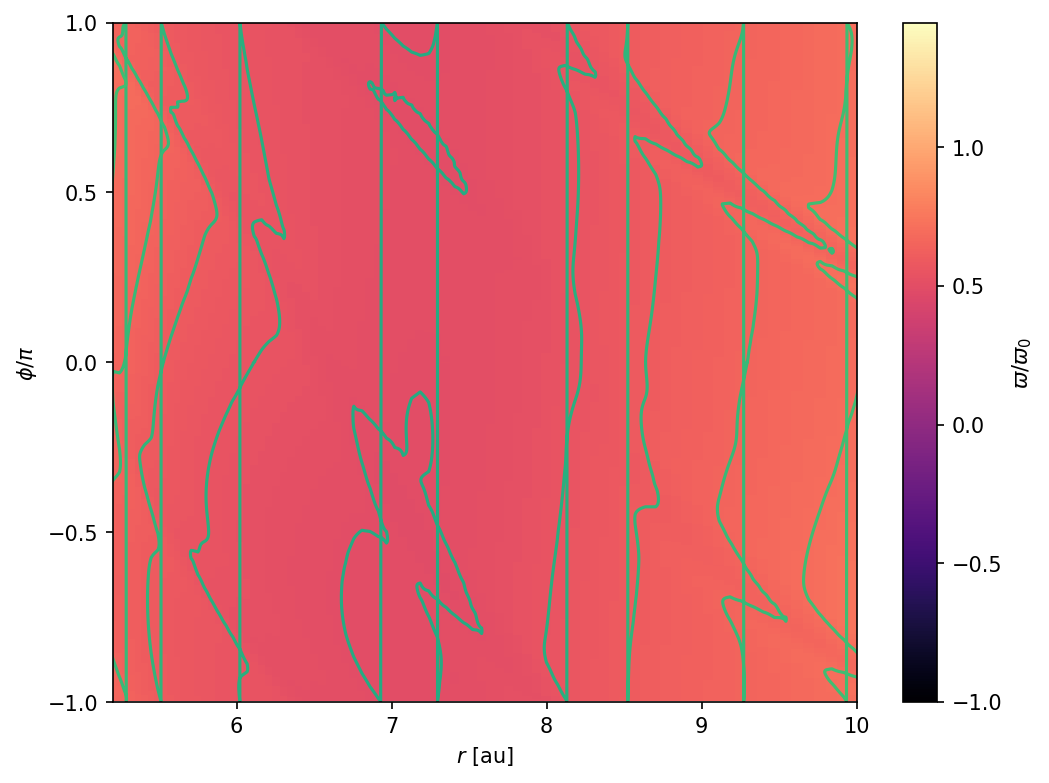

In [200]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(8,6),dpi=150)
# ax.set_xscale("log")

Z = vortensity
cmap = "magma"
norm = colors.Normalize(vmin=levels[0], vmax=levels[-1])
img = ax.pcolormesh(Xc, Yc/np.pi, Z,cmap=cmap,norm=norm, rasterized=True, shading="auto")

ax.contour(Xc, Yc/np.pi, Z, levels=levels)

show_bounding_lines = False
show_bounding_points = True
show_fits = True

def plot_vline_periodic(ax, x, y, dy, **kwargs):
    y = (y+1) % 2 - 1
    print(x,y,dy)
    at_upper_bnd = y + dy > 1
    at_lower_bnd = y - dy < -1
    if at_upper_bnd:
        line, = ax.plot([x, x], [y-dy, 1], **kwargs)
        c = line.get_color()
        ls = line.get_linestyle()
        lw = line.get_linewidth()
        ax.plot([x,x], [-1, y-2+dy], ls=ls, lw=lw, c=c)
    elif at_lower_bnd:
        line, = ax.plot([x, x], [y+dy, -1], **kwargs)
        c = line.get_color()
        ls = line.get_linestyle()
        lw = line.get_linewidth()
        ax.plot([x,x], [1, y+2-dy], ls=ls, lw=lw, c=c)
    else:
        ax.plot([x, x], [y-dy, y+dy], **kwargs)

        

for n,vort in enumerate(vortices):
    cmap = "Blues" if n==1 else "Greys"
    ax.contour(Xc, Yc/np.pi, vort["mask"], cmap="Blues")
    x,y = vort["vortensity_min_pos"]
    ax.plot([x],[y/np.pi],"x")
    
    if show_bounding_lines:
        for key in ["rmin", "rmax"]:
            ax.axvline(vort[key])
        for key in ["phimin", "phimax"]:
            ax.axhline(vort[key]/np.pi)

    if show_bounding_points:
        for key in ["top", "bottom", "left", "right"]:
            x = Xc[vort[key]]
            y = Yc[vort[key]]/np.pi
            ax.plot([x], [y], "x")

    fit_color = "C1"
    if show_fits:
        try:
            r0 = vort["vortensity_fit_r_x0"]
            sigma_r = vort["vortensity_fit_r_sigma"]
            phi0 = vort["vortensity_fit_phi_x0"]/np.pi
            sigma_phi = vort["vortensity_fit_phi_sigma"]/np.pi
            phi0 = ((phi0+1)%2)-1
            ax.plot([r0 + sigma_r, r0 - sigma_r], [phi0, phi0], ":", color=fit_color, lw=2)
            plot_vline_periodic(ax, r0, phi0, sigma_phi, ls=":", color=fit_color, lw=2)
            
            r0 = vort["sigma_fit_r_x0"]
            sigma_r = vort["sigma_fit_r_sigma"]
            phi0 = vort["sigma_fit_phi_x0"]/np.pi
            phi0 = ((phi0+1)%2)-1
            sigma_phi = vort["sigma_fit_phi_sigma"]/np.pi
            ax.plot([r0 + sigma_r, r0 - sigma_r], [phi0, phi0], "-", lw=2, color=fit_color, alpha=0.5)
            plot_vline_periodic(ax, r0, phi0, sigma_phi, ls="-", color=fit_color, lw=2, alpha=0.5)
            

            e = Ellipse(xy=[r0, phi0], width=2*sigma_r, height=2*sigma_phi, angle=0, fc="None", lw=2, edgecolor=fit_color)
            ax.add_artist(e)
            e.set_zorder(1000)
            e.set_clip_box(ax.bbox)
            e = Ellipse(xy=[r0, phi0+2*(1 if phi0<0 else -1)], width=2*sigma_r, height=2*sigma_phi, angle=0, fc="None", lw=2, edgecolor=fit_color)
            ax.add_artist(e)
            e.set_zorder(1000)
            e.set_clip_box(ax.bbox)

        except KeyError:
            pass
            
ax.set_xlabel(r"$r$ [au]")
ax.set_ylabel(r"$\phi / \pi$")
ax.set_yticks([-1, -0.5, 0, 0.5, 1])

ax.set_xlim(5.2, 10)
ax.set_ylim(-1,1)

cbar = fig.colorbar(img, ax=ax)
cbar.set_label(r"$\varpi/\varpi_0$")

7.411928114849769 -0.6787598810164117 0.166320981382832


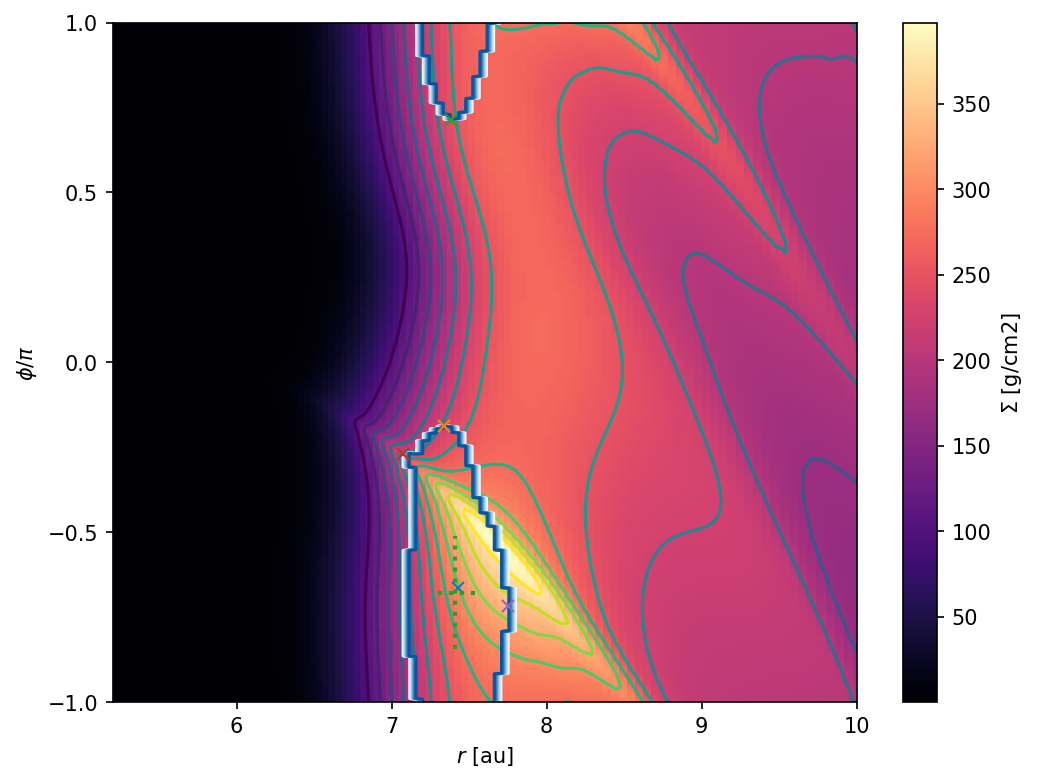

In [161]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(8,6),dpi=150)
# ax.set_xscale("log")

Z = Rho
solar_to_cgs = (1*u.solMass/u.au**2).to_value("g/cm2")
Z = Z*solar_to_cgs
cmap = "magma"

vmax = vortices[0]["sigma_max"]*solar_to_cgs
norm = colors.Normalize(vmin=1e-2, vmax=vmax)
img = ax.pcolormesh(Xc, Yc/np.pi, Z,cmap=cmap,norm=norm, rasterized=True, shading="auto")

ax.contour(Xc, Yc/np.pi, Z, levels=np.arange(100,vmax,25))

show_bounding_lines = False
show_bounding_points = True
show_fits = True

def plot_vline_periodic(ax, x, y, dy, **kwargs):
    y = (y+1) % 2 - 1
    print(x,y,dy)
    at_upper_bnd = y + dy > 1
    at_lower_bnd = y - dy < -1
    if at_upper_bnd:
        line, = ax.plot([x, x], [y-dy, 1], **kwargs)
        c = line.get_color()
        ls = line.get_linestyle()
        lw = line.get_linewidth()
        ax.plot([x,x], [-1, y-2+dy], ls=ls, lw=lw, c=c)
    elif at_lower_bnd:
        line, = ax.plot([x, x], [y+dy, -1], **kwargs)
        c = line.get_color()
        ls = line.get_linestyle()
        lw = line.get_linewidth()
        ax.plot([x,x], [1, y+2-dy], ls=ls, lw=lw, c=c)
    else:
        ax.plot([x, x], [y-dy, y+dy], **kwargs)

        

for n,vort in enumerate(vortices):
    cmap = "Blues" if n==1 else "Greys"
    ax.contour(Xc, Yc/np.pi, vort["mask"], cmap="Blues")
    x,y = vort["vortensity_min_pos"]
    ax.plot([x],[y/np.pi],"x")
    
    if show_bounding_lines:
        for key in ["rmin", "rmax"]:
            ax.axvline(vort[key])
        for key in ["phimin", "phimax"]:
            ax.axhline(vort[key]/np.pi)

    if show_bounding_points:
        for key in ["top", "bottom", "left", "right"]:
            x = Xc[vort[key]]
            y = Yc[vort[key]]/np.pi
            ax.plot([x], [y], "x")

    fit_color = "C2"
    if show_fits:
        try:
            r0 = vort["vortensity_fit_r_x0"]
            sigma_r = vort["vortensity_fit_r_sigma"]
            phi0 = vort["vortensity_fit_phi_x0"]/np.pi
            sigma_phi = vort["vortensity_fit_phi_sigma"]/np.pi
            phi0 = ((phi0+1)%2)-1
            ax.plot([r0 + sigma_r, r0 - sigma_r], [phi0, phi0], ":", color=fit_color, lw=2)
            plot_vline_periodic(ax, r0, phi0, sigma_phi, ls=":", color=fit_color, lw=2)
            
            r0 = vort["sigma_fit_r_x0"]
            sigma_r = vort["sigma_fit_r_sigma"]
            phi0 = vort["sigma_fit_phi_x0"]/np.pi
            phi0 = ((phi0+1)%2)-1
            sigma_phi = vort["sigma_fit_phi_sigma"]/np.pi
            ax.plot([r0 + sigma_r, r0 - sigma_r], [phi0, phi0], "-", lw=2, color=fit_color, alpha=0.5)
            plot_vline_periodic(ax, r0, phi0, sigma_phi, ls="-", color=fit_color, lw=2, alpha=0.5)
            

            e = Ellipse(xy=[r0, phi0], width=2*sigma_r, height=2*sigma_phi, angle=0, fc="None", lw=2, edgecolor=fit_color)
            ax.add_artist(e)
            e.set_zorder(1000)
            e.set_clip_box(ax.bbox)
            e = Ellipse(xy=[r0, phi0+2*(1 if phi0<0 else -1)], width=2*sigma_r, height=2*sigma_phi, angle=0, fc="None", lw=2, edgecolor=fit_color)
            ax.add_artist(e)
            e.set_zorder(1000)
            e.set_clip_box(ax.bbox)

        except KeyError:
            pass
            
ax.set_xlabel(r"$r$ [au]")
ax.set_ylabel(r"$\phi / \pi$")
ax.set_yticks([-1, -0.5, 0, 0.5, 1])

ax.set_xlim(5.2, 10)
ax.set_ylim(-1,1)

cbar = fig.colorbar(img, ax=ax)
cbar.set_label(r"$\Sigma$ [g/cm2]")

Plot vortensity

In [14]:
xlims = [5.2, 10]

<ipython-input-15-f43c07e51f5a>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(X,Y,Z,cmap=cmap,norm=norm)


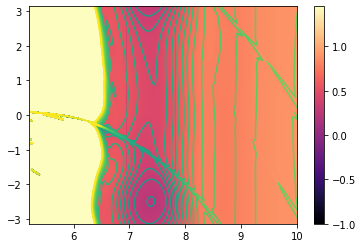

In [15]:
fig, ax = plt.subplots()
Z = vortensity
cmap = "magma"
norm = colors.Normalize(vmin=levels[0], vmax=levels[-1])
img = ax.pcolormesh(X,Y,Z,cmap=cmap,norm=norm)
ax.set_xlim(xlims)
ax.contour(Xc, Yc, vortensity, levels=levels)

cbar = fig.colorbar(img, ax=ax)

Detect vortex

f_Sigma 2.0
threshold 0.7


<ipython-input-16-aadfc9b11623>:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(X,Y,vortensity,cmap=cmap,norm=norm)


argmin ind 1317077 inds (643, 213) x 7.394325293735803 y -2.488116837951 Zmin 0.24722054060712212
normalized Z 0.4052094314457491
ratio rho_avg / rho0 1.6390605345762905
ratio rho_max / rho0 2.177231716025159


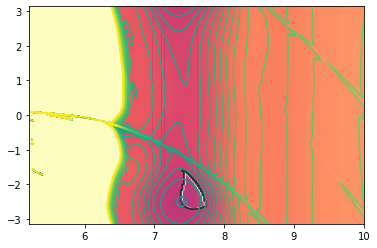

In [16]:
rmin = 5.2
rmax = 10

mask_loc_inner = R_c.to_value("au") < rmin
mask_loc_outer = R_c.to_value("au") > rmax
mask_loc = np.logical_or(mask_loc_inner, mask_loc_outer)


n_overshoot_vort = 2
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


n_overshoot_Sigma = 2
f_Sigmas = [2.0, 1.9, 1.8, 1.7, 1.6, 1.5]

for vorticity_th in thresholds:
    mask_vorticity = vorticity > vorticity_th
    for f_Sigma in f_Sigmas:
        mask_dens = Rho < f_Sigma * Rho_background
        mask = np.logical_or(mask_loc, mask_dens)
        mask = np.logical_or(mask, mask_vorticity)
        if np.sum(mask == 0) < 1000:
            continue
        else:
            if n_overshoot_Sigma <= 0:
                break
            else:
                n_overshoot_Sigma -= 1
                continue
    if np.sum(mask == 0) > 0:
        if n_overshoot_vort <= 0:
            print("f_Sigma",f_Sigma)
            print("threshold", vorticity_th)
            break
        else:
            n_overshoot_vort -= 1

vals = np.ma.masked_array(vortensity, mask=mask)

Zmin = np.min(vals)

ind = np.argmin(vals, axis=None)
inds = np.unravel_index(ind, vals.shape)
x = X[inds]
y = Y[inds]

fig, ax = plt.subplots()
img = ax.pcolormesh(X,Y,vortensity,cmap=cmap,norm=norm)
ax.contour(Xc, Yc, mask, cmap="Greys")
ax.contour(Xc, Yc, vortensity, levels=levels)

print("argmin", "ind", ind, "inds", inds, "x", x, "y", y, "Zmin", Zmin)
ax.plot(x, y, "x")
ax.set_xlim(xlims)

ix = inds[0]
iy = inds[1]
rho_avg = np.average(Rho[ix, :])
rho_max = np.max(Rho[ix, :])
rho0 = np.average(Rho_background[ix, :])

print("normalized Z", Zmin * rho_avg / rho0)
print("ratio rho_avg / rho0", rho_avg / rho0)
print("ratio rho_max / rho0", rho_max / rho0)

Detect closed regions in the contour plot

In [17]:
Rc = Xc
view_min = np.argmin(Rc[:,0] < xlims[0])
view_max = np.argmin(Rc[:,0] < xlims[1])
print(view_min, view_max)

528 743


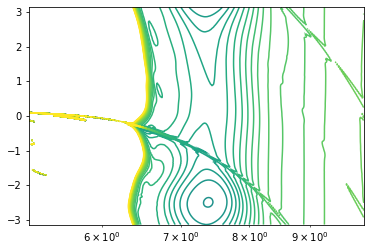

In [18]:
fig, ax = plt.subplots()
vmi = view_min
vma = view_max
img = ax.contour(Xc[vmi:vma,:], Yc[vmi:vma,:], vortensity[vmi:vma,:], levels=levels)
ax.set_xscale("log")

Make an image out of the contour lines

In [19]:
def fig2rgb_array(fig):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    return np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

In [20]:
vmi = view_min
vma = view_max
data_view = vortensity[vmi:vma,:]

Nx, Ny = data_view.shape
int_aspect = int(np.max([Nx/Ny, Ny/Nx]))

if int_aspect >= 2:
    if Nx < Ny:
        CNx = int_aspect*Nx
        CNy = Ny
    else:
        CNx = Nx
        CNy = int_aspect*Ny

if min(CNx, CNy) < 1000:
    supersample = int(np.ceil(1000/min(CNx, CNy)))
else:
    supersample = 1

CNx *= supersample
CNy *= supersample
        
print(f"Nx {Nx}, Ny {Ny}, int_aspect {int_aspect}, supersample {supersample}, CNx {CNx}, CNy {CNy}")
        
fig = plt.figure(frameon=False, figsize=(CNx,2*CNy), dpi=1)
#fig.set_size_inches(w,h)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

def periodically_extend(arr):
    Hhalf = int(arr.shape[1]/2)
    rv = np.concatenate(
        [arr[:,Hhalf:],
         arr,
         arr[:,:Hhalf]],
        axis=1
    )
    return rv
Zpe = periodically_extend(vortensity[vmi:vma,:])
Xpe = periodically_extend(Xc[vmi:vma,:])
Ype = periodically_extend(Yc[vmi:vma,:])

img = ax.contour(Zpe.transpose()
                 ,levels=levels, linewidths=CNx/1000, antialiased=False)

# ax.set_xlim(xlims)

# img = ax.contour(Xc[vmi:vma,:], Yc[vmi:vma,:], vortensity[vmi:vma,:]
#                  , levels=levels, linewidths=CNx/1000)

# ax.set_xscale("log")

# fig.canvas.draw()
# img_data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
# img_data = img_data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
# img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
img_data = fig2rgb_array(fig)
img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
plt.close(fig)

Nx 215, Ny 2048, int_aspect 9, supersample 1, CNx 1935, CNy 2048


<ipython-input-19-669bc3611ab9>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)


In [21]:
img_data.shape

(4096, 1935)

## Threshold contour image for full contrast

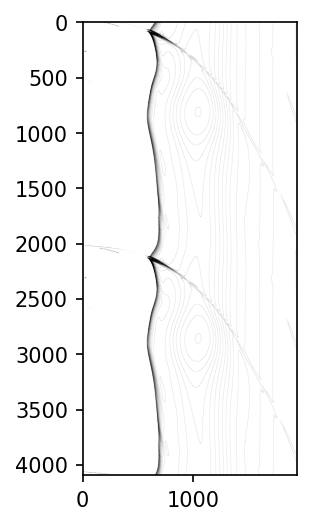

In [22]:
ret,thresh = cv2.threshold(img_data,250,255,0)
fig, ax = plt.subplots(dpi=150)
ax.imshow(thresh, cmap="Greys_r")

## Extract contours and construct hierarchy

In [23]:
# contours, hierarchy = cv2.findContours(
#         img_data, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
print("number of contours", len(contours))

contours_dict = { n : { "cnt" : cnt, "n" : n } for n, cnt in enumerate(contours) }

areas = [cv2.contourArea(c) for c in contours]
for n, d in enumerate(contours_dict.values()):
    d["area"] = areas[n]

sort_inds = np.argsort(areas)
ind_max = sort_inds[-1]
cnt_max = contours[ind_max]
contours_sorted = [contours_dict[i] for i in sort_inds]

# take the up to 100 largest patches
contours_largest = [contours_dict[i] for i in [n for n in sort_inds[::-1]][:100]]

number of contours 4529


## Extract closed contours

In [24]:
aspect_ratio_max = np.inf

contours_convex = []
for n, contour in enumerate(contours_largest):
    cnt = contour["cnt"]
    l = cv2.arcLength(cnt,True)
    contour["arcLength"] = l
    a = contour["area"]
    leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
    rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])
    topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
    bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])
    dx = rightmost[0] - leftmost[0]
    dy = bottommost[1] - topmost[1]
    
    Nh = int(thresh.shape[0]/2)
    Nq = int(thresh.shape[0]/4)
    
    # sort out mirrors of contours fully contained in original area
    if bottommost[1] < Nq or topmost[1] > 3*Nq:
        continue

    is_not_too_elongated = dx >0 and dy >0 and max(dx/dy, dy/dx) < aspect_ratio_max
    is_area_larget_delimiter = l  > 0 and a > l
    is_not_spanning_whole_height = dy < 0.5*0.95*thresh.shape[0]

    if not(is_not_too_elongated and is_area_larget_delimiter and is_not_spanning_whole_height):
        continue
    
#     contours_convex.append(contour)
#     continue
    
    # sort out the lower of mirror images
    bounding_hor = np.array([ rightmost[0], leftmost[0]] )
    bounding_vert = np.array([ topmost[1], bottommost[1] ])
    contour["bottom_extended"] = bottommost
    contour["top_extended"] = topmost
    contour["left_extended"] = leftmost
    contour["right_extended"] = rightmost
    contour["bounding_hor"] = bounding_hor
    contour["bounding_vert"] = bounding_vert
    
    to_del = None
    found_mirror = False
    for k,c in enumerate(contours_convex):
        same_hor = (bounding_hor == c["bounding_hor"]).all()
        same_vert = (np.abs(bounding_vert % Nh - c["bounding_vert"] % Nh) < 20).all()
        if same_hor and same_vert:
            if bounding_vert[1] > c["bounding_vert"][1]:
                to_del = k
            found_mirror = True
            break
    
    if found_mirror:
        if to_del is not None:
            del contours_convex[to_del]
            contours_convex.append(contour)
    else:
        contours_convex.append(contour)
    
    
print("number of convex contours", len(contours_convex))

print([c["area"] for c in contours_convex])

# cv2.drawContours(dst, contours, -1, (255, 255, 0), -1)
# cv2.drawContours(dst, contours_convex, -1, (255, 255, 0), -1)

number of convex contours 32
[359436.5, 350841.5, 214700.0, 210016.5, 191864.0, 134494.0, 133550.0, 131329.0, 109592.5, 91581.5, 73535.0, 71279.0, 31848.0, 10457.0, 9834.5, 9801.5, 5768.0, 5482.5, 4711.5, 4063.0, 3556.0, 3516.5, 2323.0, 1707.0, 1180.5, 1016.0, 426.5, 259.5, 151.5, 115.0, 109.0, 105.0]


In [25]:
max_ellipse_deviation = 0.15

candidates = {}
for contour in contours_convex:
    cnt = contour["cnt"]
    ellipse = cv2.fitEllipse(cnt)
    
    im_shape = np.zeros(thresh.shape)
    cv2.drawContours(im_shape, [cnt], 0, (255, 255, 255), -1)

    im_ellipse = np.zeros(thresh.shape)
    im_ellipse = cv2.ellipse(im_ellipse,ellipse,(255,255,255),-1)
    
    difference = np.abs(im_shape - im_ellipse)
    difference_area = np.sum(difference/255)
    
    rel_delta = difference_area / contour["area"]
    
    
    if rel_delta > max_ellipse_deviation:
        continue
    
    contour["mask_extended"] = im_shape
    candidates[contour["n"]] = contour
    
    
#     fig, ax = plt.subplots(figsize=(6,4), dpi=150)
#     im = np.zeros(list(thresh.shape) + [3])
#     cv2.drawContours(im, [cnt], 0, (255, 255, 255), -1)
    
#     im = cv2.ellipse(im,ellipse,(255,0,0),4)
#     ax.imshow(im, cmap = 'gray', interpolation = 'bicubic')
    
#     n = contour["n"]
#     ax.set_title(f"{n}, delta area = {difference_area}, rel delta area {rel_delta:.3f}")

print([c["area"] for c in candidates.values()])

[214700.0, 210016.5, 134494.0, 131329.0, 73535.0, 71279.0, 5768.0, 4711.5, 4063.0, 3556.0, 2323.0, 1707.0, 109.0]


(957, 2361) (1015, 3306)


Text(0.5, 1.0, 'mask_reduced (2048, 1935)')

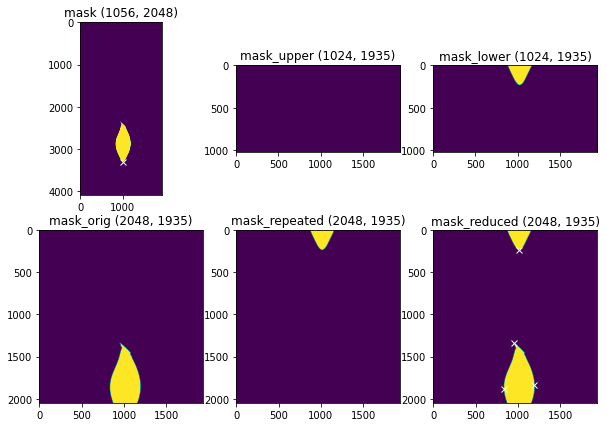

In [26]:
candidate_list = [c for c in candidates.values()]
c = candidate_list[0]
mask_extended = c["mask_extended"]
# reduce back to normal image size
Nh = int(mask_extended.shape[0]/2)
Nq = int(mask_extended.shape[0]/4)
mask_lower = mask_extended[3*Nq:, :]
mask_upper = mask_extended[:Nq, :]
mask_repeated = np.concatenate([mask_lower, mask_upper])
mask_orig = mask_extended[Nq:3*Nq, :]
mask_reduced = np.logical_or(mask_orig, mask_repeated)

cnt = c["cnt"]
leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])
topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])

print(topmost, bottommost)

fig, axes = plt.subplots(2,3, figsize=(10,7))
axes = axes.ravel()

axes[0].imshow(mask_extended)
x = bottommost[0]
y = bottommost[1]
axes[0].plot([x],[y], "x", color="white")


axes[1].imshow(mask_upper)
axes[2].imshow(mask_lower)
axes[3].imshow(mask_orig)
axes[4].imshow(mask_repeated)

def map_ext_pnt_to_orig(pnt):
    x = pnt[0]
    y = pnt[1]
    if y > Nq and y <= 3*Nq:
        y -= Nq
    elif y < Nq:
        y += Nq
    elif y > 3*Nq:
        y -= 3*Nq
    return (x,y)
    
axes[5].imshow(mask_reduced)
x, y = map_ext_pnt_to_orig(bottommost)
axes[5].plot([x],[y], "x", color="white")
x, y = map_ext_pnt_to_orig(topmost)
axes[5].plot([x],[y], "x", color="white")
x, y = map_ext_pnt_to_orig(leftmost)
axes[5].plot([x],[y], "x", color="white")
x, y = map_ext_pnt_to_orig(rightmost)
axes[5].plot([x],[y], "x", color="white")


# set titles
axes[0].set_title(f"mask {mask.shape}")
axes[1].set_title(f"mask_upper {mask_upper.shape}")
axes[2].set_title(f"mask_lower {mask_lower.shape}")
axes[3].set_title(f"mask_orig {mask_orig.shape}")
axes[4].set_title(f"mask_repeated {mask_repeated.shape}")
axes[5].set_title(f"mask_reduced {mask_reduced.shape}")

## Transform the image from ellipse fitting images back to match the grid

In [27]:
Nh = int(mask_extended.shape[0]/2)
Nq = int(mask_extended.shape[0]/4)
def map_ext_pnt_to_orig(pnt):
    x = pnt[0]
    y = pnt[1]
    if y > Nq and y <= 3*Nq:
        y -= Nq
    elif y < Nq:
        y += Nq
    elif y > 3*Nq:
        y -= 3*Nq
    return (x,y)

for contour in candidates.values():
    mask_extended = contour["mask_extended"]
    # reduce back to normal image size
    Nh = int(mask_extended.shape[0]/2)
    Nq = int(mask_extended.shape[0]/4)
    mask_lower = mask_extended[3*Nq:, :]
    mask_upper = mask_extended[:Nq, :]
    mask_repeated = np.concatenate([mask_lower, mask_upper])
    mask_orig = mask_extended[Nq:3*Nq, :]
    mask_reduced = np.logical_or(mask_orig, mask_repeated)
    
    # fit back to original data shape
    mask = mask_reduced.transpose()[:,::-1]
    mask = mask[::supersample,::supersample]
    if int_aspect >= 2:
        if Nx < Ny:
            mask = mask[::int_aspect,:]
        else:
            mask = mask[:,::int_aspect]
    mask = np.array(mask, dtype=bool)
    contour["mask"] = mask
    
    for key in ["bottom", "top", "left", "right"]: 
        pnt = contour[key + "_extended"]
        x, y = map_ext_pnt_to_orig(pnt)
        y = Nh - y
        x /= supersample
        y /= supersample
        if Nx < Ny:
            x /= int_aspect
        else:
            y /= int_aspect
        x = int(x)
        y = int(y)
        contour[key + "_view"] = (x,y)
        contour[key] = (x + vmi, y)
        

## Calculate mass of cells

In [28]:
mass = A*Rho

mass_background = A*Rho_background

mass_view = mass[vmi:vma,:]
mass_background_view = mass_background[vmi:vma,:]
vortensity_view = vortensity[vmi:vma,:]
vorticity_view = vorticity[vmi:vma,:]

Xc_view = Xc[vmi:vma,:]
Yc_view = Yc[vmi:vma,:]
Rho_view = Rho[vmi:vma,:]

## Show the candidates

<ipython-input-29-cbb0d62cadf6>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(Xc_view, Yc_view/np.pi, vortensity_view,cmap=cmap,norm=norm, rasterized=True)


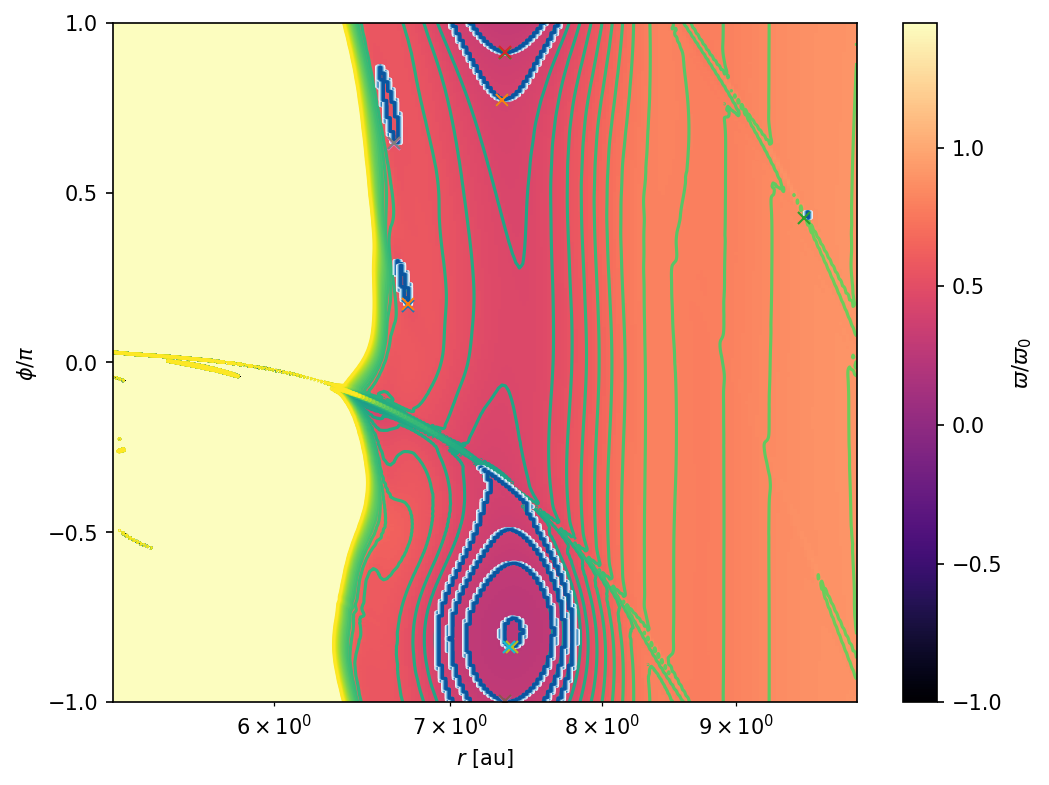

In [29]:
fig, ax = plt.subplots(figsize=(8,6),dpi=150)
ax.set_xscale("log")

Z = vortensity
cmap = "magma"
norm = colors.Normalize(vmin=levels[0], vmax=levels[-1])
img = ax.pcolormesh(Xc_view, Yc_view/np.pi, vortensity_view,cmap=cmap,norm=norm, rasterized=True)

ax.contour(Xc_view, Yc_view/np.pi, vortensity_view, levels=levels)

for n, contour in enumerate(candidates.values()):
    cmap = "Blues" if n==1 else "Greys"
    ax.contour(Xc_view, Yc_view/np.pi, contour["mask"], cmap="Blues")
    ix, iy = contour["bottom_view"]
    x = Xc_view[ix, iy]
    y = Yc_view[ix, iy]
    ax.plot([x], [y/np.pi], "x")
    
ax.set_xlabel(r"$r$ [au]")
ax.set_ylabel(r"$\phi / \pi$")
ax.set_yticks([-1, -0.5, 0, 0.5, 1])

cbar = fig.colorbar(img, ax=ax)
cbar.set_label(r"$\varpi/\varpi_0$")

## Generate ancestor list 

The hierarchy generated by opencv in the contour finder outputs a list with the syntax
```
[Next, Previous, First_Child, Parent]
```
If any of those is not available its encoded  by -1.

In [30]:
for c in candidates.values():
    ancestors = []
    n_parent = c["n"]
    for n in range(1000):
        n_parent = hierarchy[0,n_parent,3]
        if n_parent == -1 or n_parent not in candidates:
            break
        ancestors.append(n_parent)
    c["ancestors"] = ancestors
    print(c["n"], ancestors)

4306 []
4307 [4306]
4308 [4307, 4306]
4309 [4308, 4307, 4306]
4310 [4309, 4308, 4307, 4306]
4311 [4310, 4309, 4308, 4307, 4306]
3912 []
3913 [3912]
4312 [4311, 4310, 4309, 4308, 4307, 4306]
4313 [4312, 4311, 4310, 4309, 4308, 4307, 4306]
3910 []
3911 [3910]
4169 []


## Construct decendents from ancestor list
This is done to avoid causing trouble when an intermediate contour is missing.

In [31]:
decendents = {}
for c in candidates.values():
    ancestors = c["ancestors"]
    for k, n in enumerate(ancestors):
        if not n in decendents or len(decendents[n]) < k:
            decendents[n] = [i for i in reversed(ancestors[:k])]

for c in candidates.values():
    if c["n"] in decendents:
        dec = decendents[c["n"]]
    else:
        dec = []
    c["decendents"] = dec
    print(c["n"], dec)

4306 [4307, 4308, 4309, 4310, 4311, 4312]
4307 [4308, 4309, 4310, 4311, 4312]
4308 [4309, 4310, 4311, 4312]
4309 [4310, 4311, 4312]
4310 [4311, 4312]
4311 [4312]
3912 []
3913 []
4312 []
4313 []
3910 []
3911 []
4169 []


## Remove children from candidates 

In [32]:
decendents = []
for c in candidates.values():
    decendents += c["decendents"].copy()
decendents = set(decendents)
candidates_bak = candidates.copy()
for n in decendents:
    del candidates[n]

## Get the mass and vortensity inside the candidates

In [33]:
vortensity_area_view = A[vmi:vma]*vortensity[vmi:vma]


for contour in candidates.values():
    try:
        mask = contour["mask"]
        contour["mass"] = np.sum(mass_view[mask])
        contour["mass_background"] = np.sum(mass_background_view[mask])
        contour["mass_enhancement"] = contour["mass"] - contour["mass_background"]
        contour["vortensity_mean"] = np.mean(vortensity_view[mask])
        contour["vortensity_median"] = np.median(vortensity_view[mask])
        contour["vortensity_min"] = np.min(vortensity_view[mask])
        contour["vortensity_max"] = np.max(vortensity_view[mask])
        contour["sigma_mean"] = np.mean(Rho_view[mask])
        contour["sigma_median"] = np.median(Rho_view[mask])
        contour["sigma_min"] = np.min(Rho_view[mask])
        contour["sigma_max"] = np.max(Rho_view[mask])
        
        
        contour["rmin"] = Xc_view[contour["left_view"]]
        contour["rmax"] = Xc_view[contour["right_view"]]
        contour["phimax"] = Yc_view[contour["top_view"]]
        contour["phimin"] = Yc_view[contour["bottom_view"]]
        contour["width"] = contour["rmax"] - contour["rmin"]
        if contour["phimax"] < contour["phimin"]:
            contour["height"] = contour["phimax"] + 2*np.pi - contour["phimin"]
        else:
            contour["height"] = contour["phimax"] - contour["phimin"]

        contour["vortensity_flux"] = np.sum(vortensity_area_view[mask])
            
    except (ValueError, KeyError):
        pass

## Remove candidates without vortensity min in center
A vortex should have at least a small dip in vortensity.
Exclude vortices for which the minimum vorticity is not at least 0.05 lower than the maximum vorticity.
Also check that vortensity < 1

In [34]:
min_vortensity_drop = 0.05
no_min = []
for n,c in candidates.items():
    cid = c["n"]
    if c["vortensity_min"] > 1:
        no_min.append(n)
        print(f"excluding {c['n']} because of min_vortensity > 1")
        continue
    vortensity_drop = c["vortensity_max"] - c["vortensity_min"]
    if vortensity_drop < min_vortensity_drop:
        cn = c["n"]
        print(f"excluding {cn} vortensity drop is {vortensity_drop} < {min_vortensity_drop}")
        no_min.append(n)
for n in no_min:
    del candidates[n]

excluding 3912 vortensity drop is 0.011954259417735646 < 0.05
excluding 3913 vortensity drop is 0.01007982451765932 < 0.05
excluding 4313 vortensity drop is 0.003561674740398535 < 0.05
excluding 3910 vortensity drop is 0.01413778545072586 < 0.05
excluding 3911 vortensity drop is 0.011209815829289371 < 0.05
excluding 4169 vortensity drop is 0.018673479381527636 < 0.05


## Calculate the position of minimum vortensity

In [35]:
for contour in candidates.values():
    mask = np.logical_not(contour["mask"])
    ind = np.argmin(np.ma.masked_array(vortensity_view, mask=mask), axis=None)
    inds = np.unravel_index(ind, vals.shape)
    x = Xc_view[inds]
    y = Yc_view[inds]
    contour["vortensity_min_pos"] = (x, y)
    contour["vortensity_min_inds"] = inds
    # print(f"(x,y) = ({x}, {y})")

## Calculate the position of maximum density

In [36]:
for contour in candidates.values():
    mask = np.logical_not(contour["mask"])
    ind = np.argmax(np.ma.masked_array(Rho_view, mask=mask), axis=None)
    inds = np.unravel_index(ind, vals.shape)
    x = Xc_view[inds]
    y = Yc_view[inds]
    contour["sigma_max_pos"] = (x, y)
    contour["sigma_max_inds"] = inds
    # print(f"(x,y) = ({x}, {y})")

## Sort vortices by mass

In [37]:
mass_sorted = [key for key in candidates]
mass_sorted = sorted(mass_sorted, key=lambda n: candidates[n]["mass"])
candidates = {n : candidates[n] for n in reversed(mass_sorted)}

## Remove duplicates by min vort location

In [38]:
to_del = []
for c in candidates.values():
    inds = c["vortensity_min_inds"]
    mass = c["mass"]
    
    for key, o in candidates.items():
        o_inds = o["vortensity_min_inds"]
        o_mass = o["mass"]
        if o_inds == inds and o_mass < mass:
            to_del.append(key)
for key in set(to_del):
    del candidates[key]

## Plot the vortex candidates on top of the vortensity data

<ipython-input-39-6a51633d166f>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(Xc_view, Yc_view/np.pi, vortensity_view,cmap=cmap,norm=norm, rasterized=True)


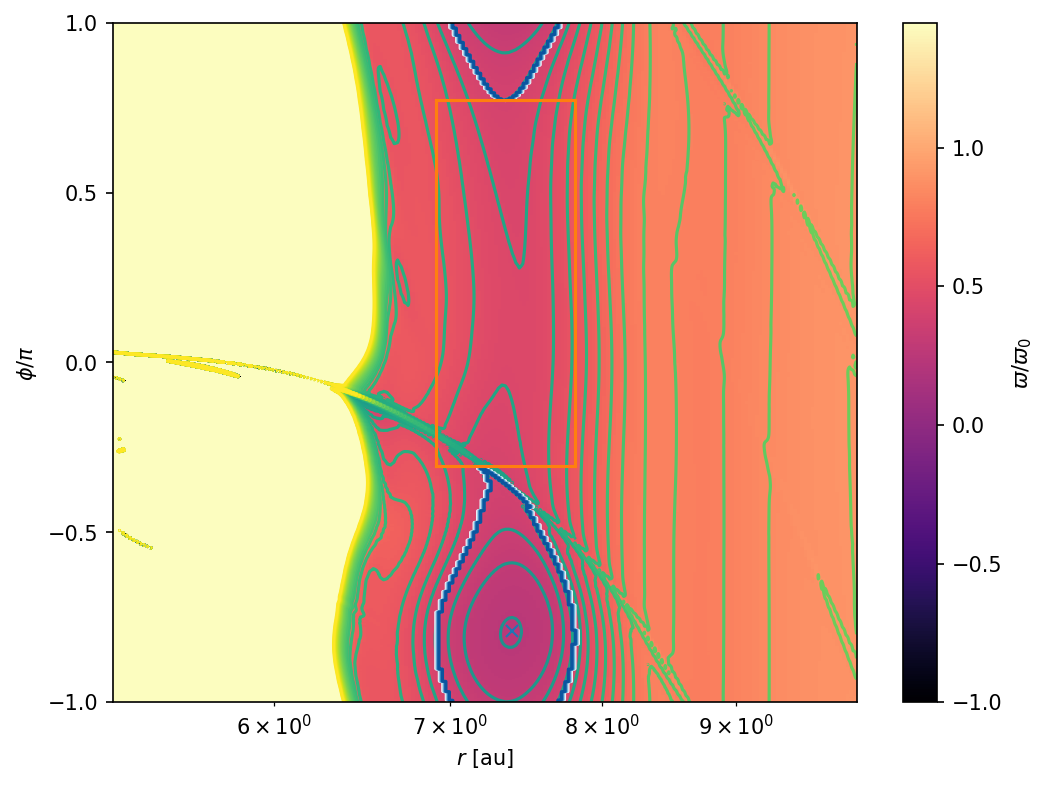

In [39]:
fig, ax = plt.subplots(figsize=(8,6),dpi=150)
ax.set_xscale("log")

Z = vortensity
cmap = "magma"
norm = colors.Normalize(vmin=levels[0], vmax=levels[-1])
img = ax.pcolormesh(Xc_view, Yc_view/np.pi, vortensity_view,cmap=cmap,norm=norm, rasterized=True)

candidates_list = [c for c in candidates.values()]
candidates_bak_list = [c for c in candidates_bak.values()]

# for contour in candidates_bak_list:
#     ax.contour(Xc[vmi:vma,:], Yc[vmi:vma,:], contour["mask"])

ax.contour(Xc_view, Yc_view/np.pi, vortensity_view, levels=levels)

for n, contour in enumerate(candidates_list):
    cmap = "Blues" if n==1 else "Greys"
    ax.contour(Xc_view, Yc_view/np.pi, contour["mask"], cmap="Blues")
    x,y = contour["vortensity_min_pos"]
    ax.plot([x], [y/np.pi], "x")
    rmin = contour["rmin"]
    rmax = contour["rmax"]
    phimin = contour["phimin"]/np.pi
    phimax = contour["phimax"]/np.pi
    ax.plot([rmin, rmin], [phimin, phimax], color="C1")
    ax.plot([rmax, rmax], [phimin, phimax], color="C1")
    ax.plot([rmin, rmax], [phimin, phimin], color="C1")
    ax.plot([rmin, rmax], [phimax, phimax], color="C1")

    

ax.set_xlabel(r"$r$ [au]")
ax.set_ylabel(r"$\phi / \pi$")
ax.set_yticks([-1, -0.5, 0, 0.5, 1])

cbar = fig.colorbar(img, ax=ax)
cbar.set_label(r"$\varpi/\varpi_0$")

## Print out some properties

In [40]:
from pprint import pprint
for vort in candidates.values():
    try:
        v = vort.copy()
        for k in ["cnt", "mask", "mask_extended","gmask"]:
            del v[k]
        pprint(v)
        mass = vort["mass"]
        vort_med = vort["vortensity_median"]
        print([x % Nh for x in vort["bounding_vert"]])
        print("strength", np.exp(-vort_med)*mass)
    except KeyError:
        pass
    print()

## Calculate the center of gravity of the vortex

In [41]:
from scipy.optimize import curve_fit

def gauss(x, y0, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + y0

class Fitter:
    def __init__(self, x, y, weights=None, autoweight=True, blow=dict(), bup=dict(), fixed=dict()):
        self.x = x
        self.y = y
        self.autoweight = autoweight
        self.weights = weights
        
        self.parameters = ["y0", "a", "x0", "sigma"]
        
        self.blow = {key : -np.inf for key in self.parameters}
        self.bup = {key : np.inf for key in self.parameters}
        self.blow["sigma"] = 0
        self.bup["sigma"] = (np.max(x)-np.min(x))
        self.blow["x0"] = np.min(x)
        self.bup["x0"] = np.max(x)
        
        for key, val in blow.items():
            self.set_lower_bound(key, val)
        for key, val in bup.items():
            self.set_upper_bound(key, val)
        
        self.fixed = fixed
    
    def set_lower_bound(self, key, value):
        if not key in self.parameters:
            raise KeyError(f"{key} is not a member of the lower bounds dict.")
        self.blow[key] = value
        
    def set_upper_bound(self, key, value):
        if not key in self.parameters:
            raise KeyError(f"{key} is not a member of the upper bounds dict.")
        self.bup[key] = value
        
    def set_fixed(self, key, value):
        if not key in self.parameters:
            raise KeyError(f"{key} is not a valid parameter.")
        self.fixed[key] = value
    
    def fit(self):
        popt, pcov = self.fit_single()
        
        if self.weights is None and self.autoweight:
            peak_value = popt[0] + popt[1] # y0 + a
            self.calc_weights(peak_value)
            popt, pcov = self.fit_single()
        return popt, pcov
    
    def calc_weights(self, peak_value):
        difference = np.abs(self.y - peak_value)
        self.weights = np.exp(-difference/np.max(difference))
    
    def fit_single(self):
        x = self.x
        y = self.y
        fixed = self.fixed
        weights = self.weights
        lower = [self.blow[key] for key in self.parameters]
        upper = [self.bup[key] for key in self.parameters]
        
        mean = sum(x * y) / sum(y)
        sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
        
        if "y0" in fixed and "a" in fixed:
            f = lambda x,x0,sig: gauss(x, fixed["y0"], fixed["a"], x0, sig)
            p0 = [mean, sigma]
            bounds = (lower[2:], upper[2:])
            popt,pcov = curve_fit(f, x, y, p0=p0, bounds=bounds, sigma=weights)
            popt = [fixed["y0"], fixed["a"], popt[0], popt[1]]
        elif "y0" in fixed:
            f = lambda x,a,x0,sig: gauss(x, fixed["y0"], a, x0, sig)
            p0 = [np.average(y),mean, sigma]
            bounds = (lower[1:], upper[1:])
            popt,pcov = curve_fit(f, x, y, p0=p0,bounds=bounds, sigma=weights)
            popt = [fixed["y0"], popt[0], popt[1], popt[2]]
        else:
            f = gauss
            p0 = [np.average(y), y[int(len(y)/2)], mean, sigma]
            bounds = (lower, upper)
            popt,pcov = curve_fit(f, x, y, p0=p0, bounds=bounds, sigma=weights)
    
        return popt, pcov

In [42]:
def combine_periodic(x,y,m,lb=-np.pi,rb=np.pi):
    """ Combine an array split at a periodic boundary. """
    if m[0] and m[-1] and not all(m):
        bnd = np.where(m==False)[0][0]
        xl = x[:bnd]
        yl = y[:bnd]
        bnd = np.where(m==False)[0][-1]
        xr = x[bnd:]
        yr = y[bnd:]
        xcom = np.append(xr, xl+(rb-lb))
        ycom = np.append(yr, yl)
        return xcom, ycom
    else:
        return x[m],y[m]

In [43]:
def plot_periodic_mask(ax, x, y, m, **kwargs):
#     print(m)
    if m[0] and m[-1] and not all(m):
        bnd = np.where(m==False)[0][0]
        xl = x[:bnd]
        yl = y[:bnd]
        line, = ax.plot(xl, yl, **kwargs)
        bnd = np.where(m==False)[0][-1]
#         print(len(x))
#         print(bnd)
        xr = x[bnd:]
        yr = y[bnd:]
        kwa = kwargs.copy()
        kwa["color"] = line.get_color()
        kwa["ls"] = line.get_linestyle()
        line, = ax.plot(xr, yr, **kwa)
        line.set_label(None)
    else:
        ax.plot(x[m],y[m],**kwargs)

def plot_periodic(ax, x, y, m=None, boundaries=(-np.pi, np.pi), **kwargs):
    if m is not None:
        plot_periodic_mask(ax, x, y, m, **kwargs)
        return
    x[x<boundaries[0]] += boundaries[1]-boundaries[0]
    m = x > boundaries[1]
    if not any(m):
        ax.plot(x,y,**kwargs)
    else:
        bnd = np.where(m==True)[0][0]
        xl = x[:bnd]
        yl = y[:bnd]
        line, = ax.plot(xl, yl, **kwargs)
        xr = x[bnd:] - (boundaries[1]-boundaries[0])
        yr = y[bnd:]
        kwa = kwargs.copy()
        kwa["color"] = line.get_color()
        kwa["ls"] = line.get_linestyle()
        line, = ax.plot(xr, yr, **kwa)
        line.set_label(None)
    


In [44]:
def plot_gauss(ax,x,y, xfull=None, double_fit=True, fixed=dict(), blow=dict(), bup=dict()):
    try:
        fitter = Fitter(x, y, blow=blow, bup=bup, fixed=fixed)
        popt, pcov = fitter.fit_single()
        ax.plot(x, gauss(x, *popt), 'r-', color="C2", label='1st fit')
        
        if double_fit:
            peak_value = popt[0] + popt[1] # y0 + a
            difference = np.abs(y - peak_value)
            w = np.exp(-difference/np.max(difference))
            fitter.weights = w
            popt,pcov = fitter.fit_single()
            
            popt, pcov = fitter.fit_single()
            ax.plot(x, 0.5*w/np.max(w)*(popt[0]+popt[1]), color="C2", ls=":", label="weights")
            ax.plot(x, gauss(x, *popt), ls='--', color="C3", lw=2, label='2nd fit')
        
        if xfull is not None:
            ax.plot(xfull, gauss(xfull, *popt), 'r-', alpha=0.2)
        return popt, pcov
    except RuntimeError:
        pass
    
def plot_gauss_periodic(ax, x, y, m=None, double_fit=True, fixed=dict(), blow=dict(), bup=dict()):
    if m is None:
        m = np.ones(len(x), dtype=bool)
    try:
        xc, yc = combine_periodic(x,y,m)
        
        fitter = Fitter(xc, yc, blow=blow, bup=bup, fixed=fixed)
        popt, pcov = fitter.fit_single()

        plot_periodic(ax, xc, gauss(xc, *popt), ls="-", color="C2", label='1st fit')
        
        if double_fit:
            peak_value = popt[0] + popt[1] # y0 + a
            difference = np.abs(yc - peak_value)
            w = np.exp(-difference/np.max(difference))
            fitter.weights = w
            popt,pcov = fitter.fit_single()
            
            plot_periodic(ax, xc, np.min(y) +  0.5*w/np.max(w)*(np.max(y)-np.min(y)), color="C2", ls=":", label="weights")
            plot_periodic(ax, xc, gauss(xc, *popt), ls="--", lw=2, color="C3", label='2nd fit')
        
        c = popt[2]
        xnew = np.linspace(c-np.pi, c+np.pi, 500, endpoint=False)
        plot_periodic(ax, xnew, gauss(xnew, *popt), ls="-", color="C3", alpha=0.2)
        return popt, pcov
    except RuntimeError:
        pass

In [45]:
def extend_vortex_mask_by_size(mask, fraction=0.25):
    L = np.sum(mask)
    dL = int(fraction*L)

    m = mask[1:] != mask[:-1]
    copy = mask.copy()
    bnd = np.where(m)[0][0]
    
    if mask[bnd+1]:
        copy[bnd-dL:bnd+1] = True
        bnd = np.where(m)[0][-1]
        copy[bnd:bnd+dL] = True
    else:
        copy[bnd:bnd+dL] = True
        bnd = np.where(m)[0][-1]
        copy[bnd-dL:bnd+1] = True
    return copy

In [46]:
def extend_vortex_mask_by_value(mask, y, ref):

    m = mask[1:] != mask[:-1]
    copy = mask.copy()
    bnd = np.where(m)[0][0]
    go_left = mask[bnd+1]
    if go_left:
        r = range(bnd, -1, -1)
    else:
        r = range(bnd, len(mask))
    last = y[bnd]
    for n in r:
        crossing_ref_up = y[n] >= ref and last < ref
        crossing_ref_down = y[n] <= ref and last > ref
        if crossing_ref_up or crossing_ref_down:
            break
        else:
            copy[n] = True
            last = y[n]
            
    bnd = np.where(m)[0][-1]
    go_left = mask[bnd+1]
    if go_left:
        r = range(bnd, -1, -1)
    else:
        r = range(bnd, len(mask))
    last = y[bnd]
    for n in r:
        crossing_ref_up = y[n] >= ref and last < ref
        crossing_ref_down = y[n] <= ref and last > ref
        if crossing_ref_up or crossing_ref_down:
            break
        else:
            copy[n] = True
            last = y[n]
    
    return copy
    

## Vortensity slices onto the vortex

avg 0.3866853063920431
c -2.482518458875915


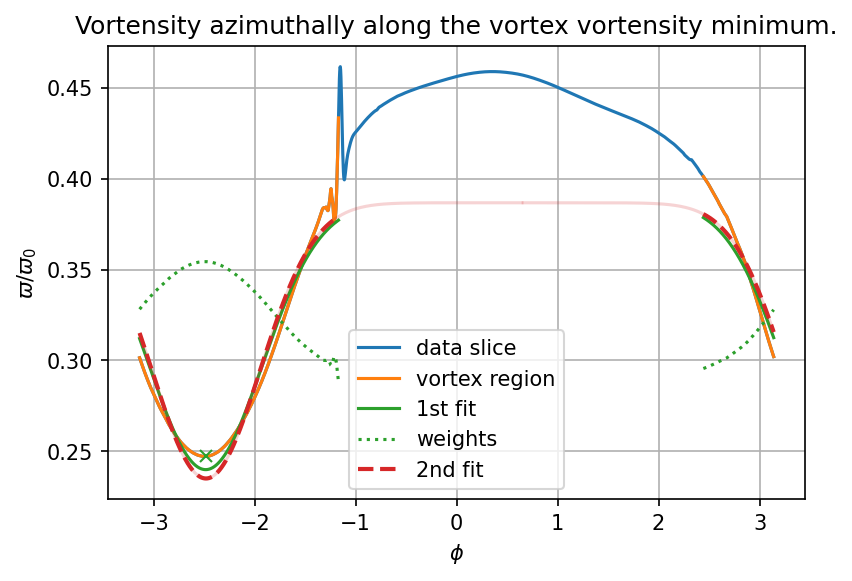

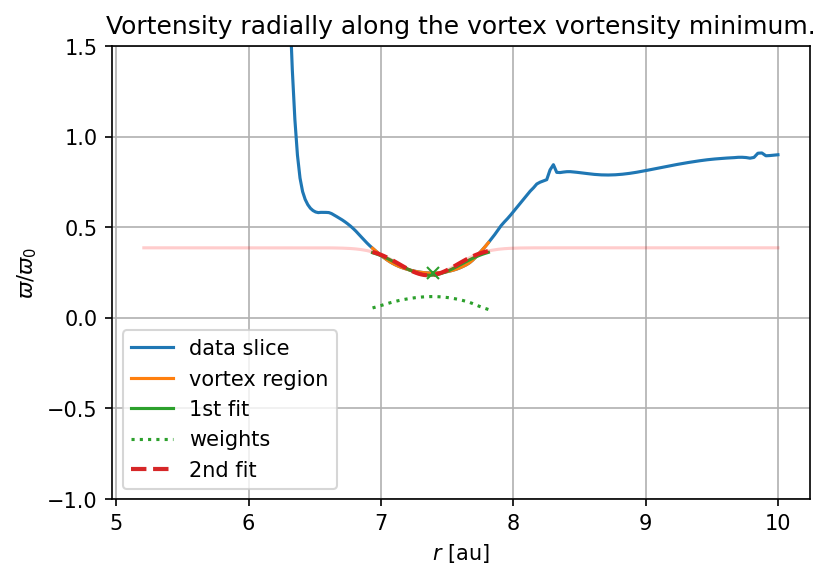

In [47]:
for vort in candidates.values():
    if "fit_sigma_center_r_ind" in vort:
        inds = (vort["fit_sigma_center_r_ind"], vort["fit_sigma_center_phi_ind"])
        mask_r = vort["fit_sigma_mask_r"]
        mask_phi = vort["fit_sigma_mask_phi"]

    else:
        inds = vort["vortensity_min_inds"]

        mask = vort["mask"]
        mask_r = mask[:, inds[1]]
        mask_phi = mask[inds[0], :]
    
    vortensity_r = vortensity_view[:, inds[1]]
    vortensity_phi = vortensity_view[inds[0], :]
    
    phi = Yc_view[inds[0],:]
    r = Xc_view[:,inds[1]]
    
#     mask_phi = extend_vortex_mask_by_size(mask_phi)
#     mask_r = extend_vortex_mask_by_size(mask_r)
    
    ref = np.average(vortensity_phi)
#     mask_phi = extend_vortex_mask_by_value(mask_phi, vortensity_phi, ref)
#     mask_r = extend_vortex_mask_by_value(mask_r, vortensity_r, ref)
    

    fig, ax = plt.subplots(dpi=150)
    ax.plot(phi, vortensity_phi, label="data slice")
    plot_periodic(ax,phi, vortensity_phi, m=mask_phi, label="vortex region")
    avg = np.average(vortensity_phi)
    print("avg", avg)
    popt, pcov = plot_gauss_periodic(ax,phi, vortensity_phi, m=mask_phi, fixed={"y0" : avg})
#     popt, pcov = plot_gauss_periodic(ax,Yc_view[inds[0],:], vortensity_phi, m=mask_phi, fixed={"y0" : 1})
#     popt, pcov = plot_gauss_periodic(ax,Yc_view[inds[0],:], vortensity_phi, m=mask_phi, blow={"y0" : avg/10}, bup={"y0": avg*2})
    ax.plot([Yc_view[inds]],[vortensity_view[inds]], "x")
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\varpi/\varpi_0$")
    ax.set_title("Vortensity azimuthally along the vortex vortensity minimum.")
    ax.legend()
    ax.grid()
#     ax.plot(Yc_view[inds[0],:], mask_phi_copy)

    c = popt[2]
    c = (c+np.pi)%(2*np.pi)-np.pi
    print("c", c)
    sig = popt[3]
    cind = np.argmin(np.abs(phi - c))
    lphi = ((c-sig)+np.pi) % (2*np.pi) - np.pi
    lind = np.argmin(np.abs(phi - lphi))
    uphi = ((c+sig)+np.pi) % (2*np.pi) - np.pi
    uind = np.argmin(np.abs(phi - uphi))
    mask = np.zeros(len(phi), dtype=bool)
    if c + sig > np.pi or c - sig < -np.pi:
        mask[lind:] = True
        mask[:uind+1] = True
    else:
        mask[lind:uind+1] = True
    vort["fit_vortensity_center_phi"] = c
    vort["fit_vortensity_center_phi_ind"] = cind
    vort["fit_vortensity_sigma_phi"] = sig
    vort["fit_vortensity_mask_phi"] = mask
    
    fig, ax = plt.subplots(dpi=150)
    ax.plot(r, vortensity_r, label="data slice")
    ax.plot(r[mask_r], vortensity_r[mask_r], label="vortex region")
    popt, pcov = plot_gauss(ax,r[mask_r], vortensity_r[mask_r], xfull=Xc_view[:,inds[1]], fixed = {"y0" : popt[0], "a" : popt[1]})
    ax.plot([Xc_view[inds]],[vortensity_view[inds]], "x")
    ax.set_xlabel(r"$r$ [au]")
    ax.set_ylabel(r"$\varpi/\varpi_0$")
    ax.set_title("Vortensity radially along the vortex vortensity minimum.")
    ax.set_ylim([-1,1.5])
    ax.legend()
    ax.grid()
#     ax.plot(Xc_view[:,inds[1]], mask_r)
#     ax.plot(Xc_view[:,inds[1]], mask_r_copy)

    c = popt[2]
    sig = popt[3]
    cind = np.argmin(np.abs(r - c))
    lr = c - sig
    lind = np.argmin(np.abs(r - lr))
    ur = c + sig
    uind = np.argmin(np.abs(r - ur))
    mask = np.zeros(len(r), dtype=bool)
    mask[lind:uind+1] = True
    vort["fit_vortensity_center_r"] = c
    vort["fit_vortensity_center_r_ind"] = cind
    vort["fit_vortensity_sigma_r"] = sig
    vort["fit_vortensity_mask_r"] = mask

    

    break

## Fitting gaussian to sigma with vortensity fit mask

c -2.4243635059942545
sigma r popt [3.635704076524401e-05, 4.979118899765856e-06, 7.369209699782263, 0.1283275413555964]
sigma center 7.369209699782263


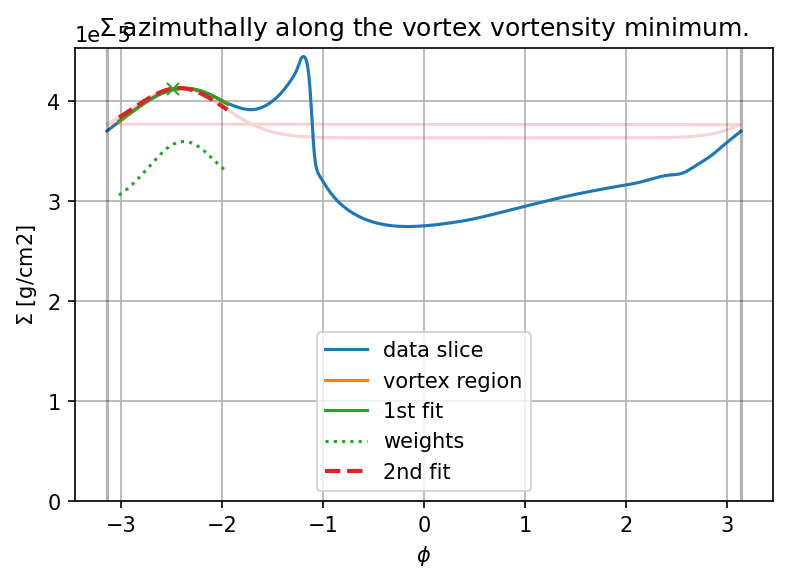

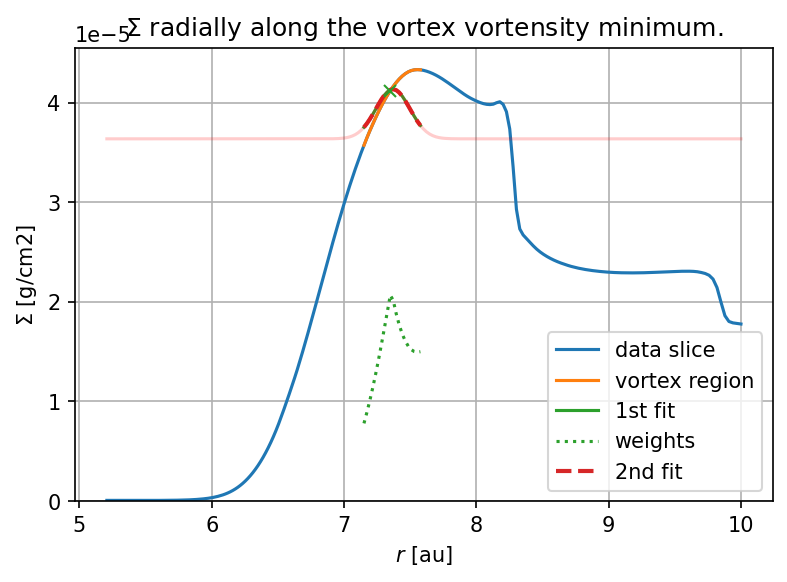

In [48]:
for vort in candidates.values():
    inds = (vort["fit_vortensity_center_r_ind"], vort["fit_vortensity_center_phi_ind"])

    mask_r = vort["fit_vortensity_mask_r"]
    mask_phi = vort["fit_vortensity_mask_phi"]
    
    sigma_r = Rho_view[:, inds[1]]
    sigma_phi = Rho_view[inds[0], :]
    

    r = Xc_view[:,inds[1]]
    phi = Yc_view[inds[0],:]
    
    fig, ax = plt.subplots(dpi=150)
    ax.plot(phi, sigma_phi, label="data slice")
    plot_periodic(ax, phi, sigma_phi, m=mask_phi, label="vortex region")
    popt, _ = plot_gauss_periodic(ax,Yc_view[inds[0],:], sigma_phi, m=mask_phi, 
                                  blow = {"y0" : 0, "a" : 0})
#                                   fixed={"y0" : 0})
    ax.plot([Yc_view[inds]],[Rho_view[inds]], "x")
    ax.axvline(np.pi, color="k", alpha=0.3)
    ax.axvline(-np.pi, color="k", alpha=0.3)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\Sigma$ [g/cm2]")
    ax.set_title(r"$\Sigma$ azimuthally along the vortex vortensity minimum.")
    ax.set_ylim(bottom=0)
    ax.legend()
    ax.grid()
    
    c = popt[2]
    c = (c+np.pi)%(2*np.pi)-np.pi
    print("c", c)
    sig = popt[3]
    cind = np.argmin(np.abs(phi - c))
    lphi = ((c-sig)+np.pi) % (2*np.pi) - np.pi
    lind = np.argmin(np.abs(phi - lphi))
    uphi = ((c+sig)+np.pi) % (2*np.pi) - np.pi
    uind = np.argmin(np.abs(phi - uphi))
    mask = np.zeros(len(phi), dtype=bool)
    if c + sig > np.pi or c - sig < -np.pi:
        mask[lind:] = True
        mask[:uind+1] = True
    else:
        mask[lind:uind+1] = True
    vort["fit_sigma_center_phi"] = c
    vort["fit_sigma_center_phi_ind"] = cind
    vort["fit_sigma_sigma_phi"] = sig
    vort["fit_sigma_mask_phi"] = mask
    
    fig, ax = plt.subplots(dpi=150)
    ax.plot(r, sigma_r, label="data slice")
    ax.plot(r[mask_r], sigma_r[mask_r], label="vortex region")
    
    popt, pcov, = plot_gauss(ax,r[mask_r], sigma_r[mask_r], xfull=Xc_view[:,inds[1]], 
#                              blow = {"y0" : 0, "a" : 0})
                             fixed = {"y0" : popt[0], "a" : popt[1]})
    ax.plot([Xc_view[inds]],[Rho_view[inds]], "x")
    ax.set_xlabel(r"$r$ [au]")
    ax.set_ylabel(r"$\Sigma$ [g/cm2]")
    ax.set_title(r"$\Sigma$ radially along the vortex vortensity minimum.")
    ax.set_ylim(bottom=0)
    ax.legend()
    ax.grid()
    
    print("sigma r popt", popt)
    c = popt[2]
    sig = popt[3]
    cind = np.argmin(np.abs(r - c))
    lr = c - sig
    lind = np.argmin(np.abs(r - lr))
    ur = c + sig
    uind = np.argmin(np.abs(r - ur))
    mask = np.zeros(len(r), dtype=bool)
    mask[lind:uind+1] = True
    print("sigma center", c)
    vort["fit_sigma_center_r"] = c
    vort["fit_sigma_center_r_ind"] = cind
    vort["fit_sigma_sigma_r"] = sig
    vort["fit_sigma_mask_r"] = mask

    break

## Fitting gaussian to sigma with contour mask

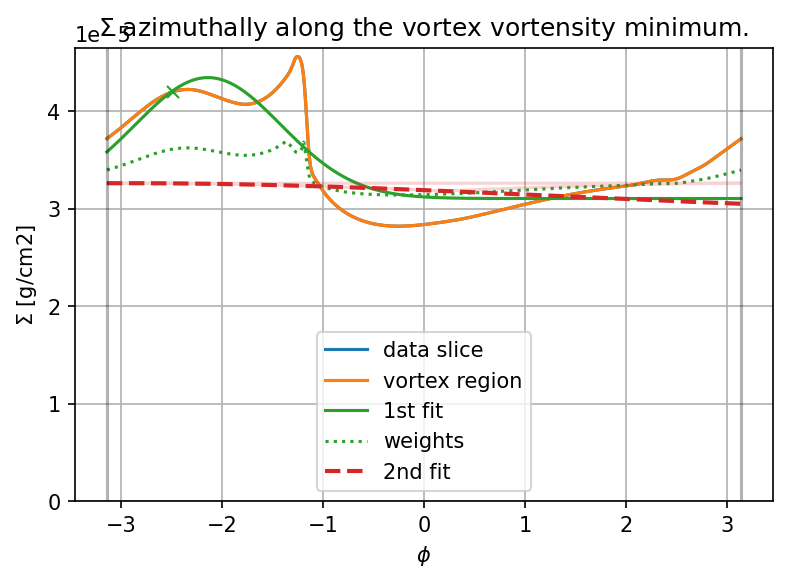

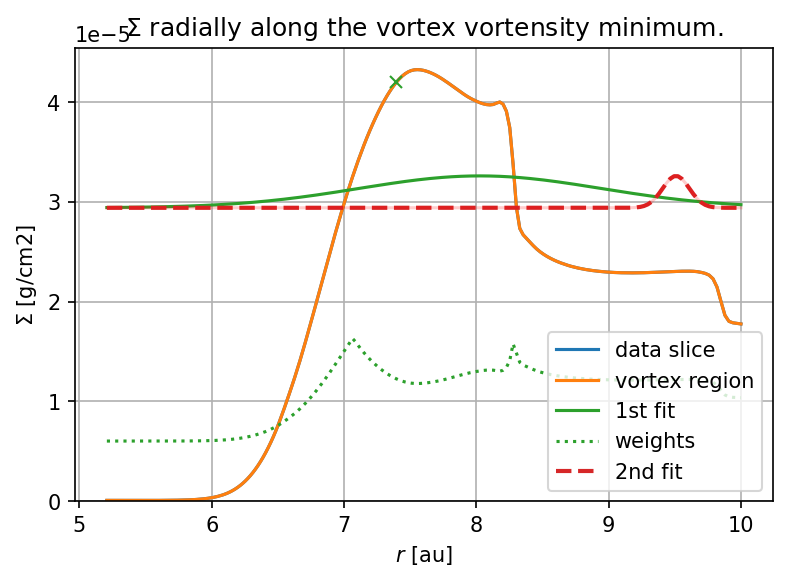

In [49]:
for vort in candidates.values():

    inds = vort["vortensity_min_inds"]
    
    mask = vort["mask"]
    mask_r = mask[:, inds[1]]
    mask_phi = mask[inds[0], :]
    
    sigma_r = Rho_view[:, inds[1]]
    sigma_phi = Rho_view[inds[0], :]
    
    vortensity_r = vortensity_view[:, inds[1]]
    vortensity_phi = vortensity_view[inds[0], :]
    
    
    ref = np.average(vortensity_phi)
    mask_phi = extend_vortex_mask_by_value(mask_phi, vortensity_phi, ref)
    mask_r = extend_vortex_mask_by_value(mask_r, vortensity_r, ref)

    fig, ax = plt.subplots(dpi=150)
    ax.plot(Yc_view[inds[0],:], sigma_phi, label="data slice")
    plot_periodic(ax, Yc_view[inds[0],:], sigma_phi, m=mask_phi, label="vortex region")
    popt, _ = plot_gauss_periodic(ax,Yc_view[inds[0],:], sigma_phi, m=mask_phi, 
                                  blow = {"y0" : 0, "a" : 0})
#                                   fixed={"y0" : 0})
#     xcom, ycom = combine_periodic(Yc_view[inds[0],:], sigma_phi, mask_phi)
#     ax.plot(xcom, ycom)
    ax.plot([Yc_view[inds]],[Rho_view[inds]], "x")
    ax.axvline(np.pi, color="k", alpha=0.3)
    ax.axvline(-np.pi, color="k", alpha=0.3)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\Sigma$ [g/cm2]")
    ax.set_title(r"$\Sigma$ azimuthally along the vortex vortensity minimum.")
    ax.set_ylim(bottom=0)
    ax.legend()
    ax.grid()
    
    fig, ax = plt.subplots(dpi=150)
    ax.plot(Xc_view[:,inds[1]], sigma_r, label="data slice")
    ax.plot(Xc_view[:,inds[1]][mask_r], sigma_r[mask_r], label="vortex region")
    plot_gauss(ax,Xc_view[:,inds[1]][mask_r], sigma_r[mask_r], xfull=Xc_view[:,inds[1]], fixed = {"y0" : popt[0], "a" : popt[1]})
    ax.plot([Xc_view[inds]],[Rho_view[inds]], "x")
    ax.set_xlabel(r"$r$ [au]")
    ax.set_ylabel(r"$\Sigma$ [g/cm2]")
    ax.set_title(r"$\Sigma$ radially along the vortex vortensity minimum.")
    ax.set_ylim(bottom=0)
    ax.legend()
    ax.grid()

    break

## Vorticity slices at the location of the vortex

mass_enhancement 0.0002026368503551091
mass_background 0.00025431391455746577
mass 0.00045695076491257487
vortensity_min 0.24722054060712212
vortensity_median 0.3297356935701508
vortensity_mean 0.32816951946196354
vortensity_max 0.4362745654425776
strength 0.34422959800088637


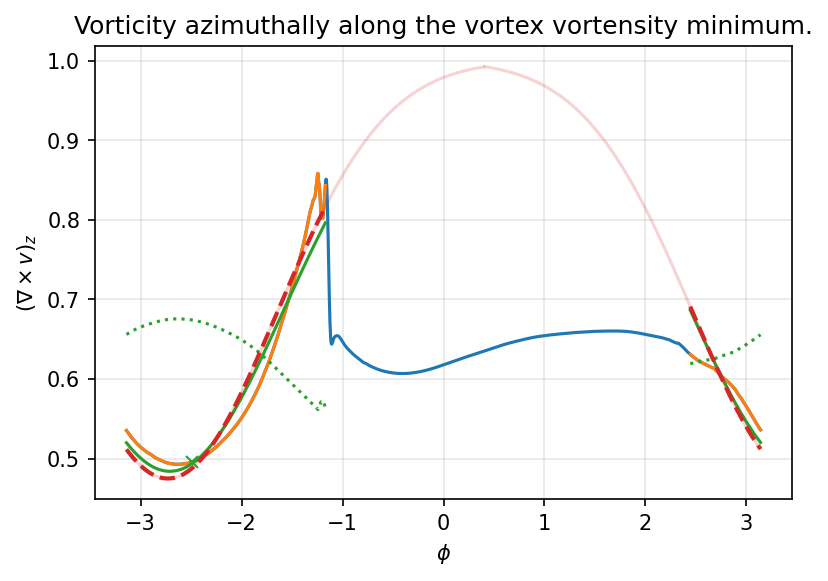

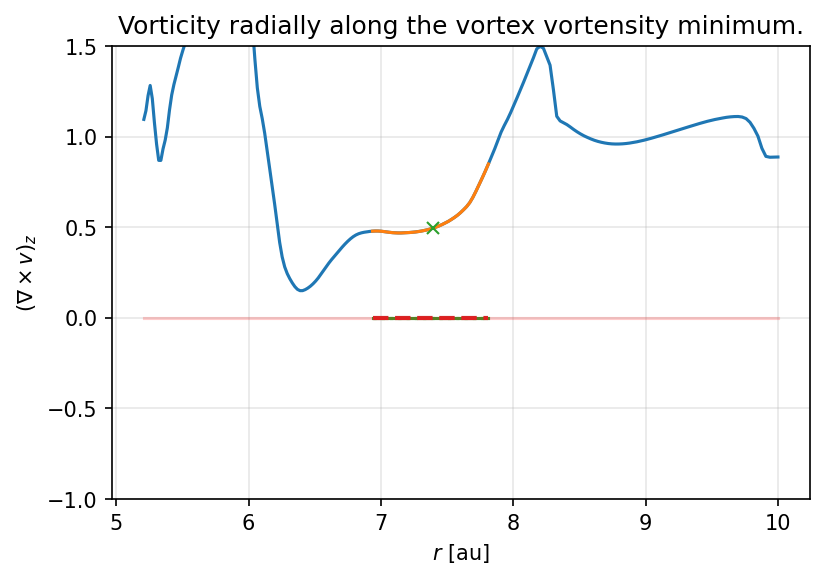

In [50]:
for vort in candidates.values():
    for v in ["mass_enhancement", "mass_background", "mass", "vortensity_min", "vortensity_median", "vortensity_mean", "vortensity_max"]:
        print(v, vort[v])
    mass = vort["mass"]/(1*u.jupiterMass).to_value("solMass")
    vort_med = vort["vortensity_median"]
    print("strength", np.exp(-vort_med)*mass)
    
    inds = vort["vortensity_min_inds"]
    
    mask = vort["mask"]
    mask_r = mask[:, inds[1]]
    mask_phi = mask[inds[0], :]
    
    vorticity_r = vorticity_view[:, inds[1]]
    vorticity_phi = vorticity_view[inds[0], :]
    
    fig, ax = plt.subplots(dpi=150)
    ax.plot(Yc_view[inds[0],:], vorticity_phi)
    plot_periodic(ax, Yc_view[inds[0],:], vorticity_phi, m=mask_phi)
    plot_gauss_periodic(ax,Yc_view[inds[0],:], vorticity_phi, m=mask_phi, fixed={"y0" : 1})
    ax.plot([Yc_view[inds]],[vorticity_view[inds]], "x")
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$(\nabla \times v)_z$")
    ax.set_title("Vorticity azimuthally along the vortex vortensity minimum.")
    ax.grid(alpha=0.3)

    fig, ax = plt.subplots(dpi=150)
    ax.plot(Xc_view[:,inds[1]], vorticity_r)
    ax.plot(Xc_view[:,inds[1]][mask_r], vorticity_r[mask_r])
    plot_gauss(ax,Xc_view[:,inds[1]][mask_r], vorticity_r[mask_r], xfull=Xc_view[:,inds[1]], fixed = {"y0" : popt[0], "a" : popt[1]})
    ax.plot([Xc_view[inds]],[vorticity_view[inds]], "x")
    ax.set_xlabel(r"$r$ [au]")
    ax.set_ylabel(r"$(\nabla \times v)_z$")
    ax.set_title("Vorticity radially along the vortex vortensity minimum.")
    ax.set_ylim([-1,1.5])
    ax.grid(alpha=0.3)
    

    break

## Extend mask to full data array size

In [51]:
for c in candidates.values():
    mask = c["mask"]
    gmask = np.concatenate(
        [np.zeros((vmi, mask.shape[1]),dtype=bool), 
        mask,
        np.zeros((Xc.shape[0]-vma, mask.shape[1]),dtype=bool)],
        axis=0)
    c["gmask"] = gmask
    c["gtop"] = (c["top"][0] + vmi, c["top"][1])
    c["gright"] = (c["right"][0] + vmi, c["right"][1])
    c["gleft"] = (c["left"][0] + vmi, c["left"][1])
    c["gbottom"] = (c["bottom"][0] + vmi, c["bottom"][1])

<ipython-input-52-cdc0c83178bd>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(Xc, Yc, vortensity,cmap=cmap,norm=norm)


IndexError: index 1162 is out of bounds for axis 0 with size 1056

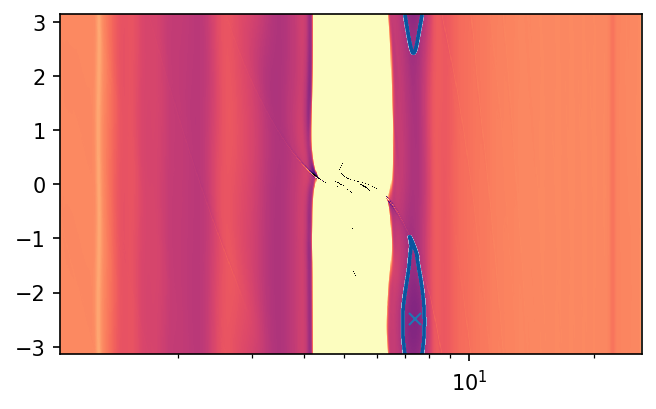

In [52]:
fig, ax = plt.subplots(figsize=(5,3),dpi=150)
ax.set_xscale("log")

Z = vortensity
cmap = "magma"
norm = colors.Normalize(vmin=-0.5, vmax=1.5)
img = ax.pcolormesh(Xc, Yc, vortensity,cmap=cmap,norm=norm)

candidates_list = [c for c in candidates.values()]

for n, contour in enumerate(candidates_list):
    cmap = "Blues" if n==1 else "Greys"
    ax.contour(Xc, Yc, contour["gmask"], cmap="Blues")
    x,y = contour["vortensity_min_pos"]
    ax.plot([x], [y], "x")
    for key in ["top", "left", "right", "bottom"]:
        key = "g" + key
        x = Xc[c[key]]
        y = Yc[c[key]]
        ax.plot([x], [y], "x")